# Table of Contents
[1. Model Preparation](#1.-Model-Preperation)
<br>
* [1.1 Reviewing, Splitting data set](#1.1-Reviewing,-splitting-dataset-into-7:3-for-training-and-testing.)
* [1.2 Plotting features against target feature](#1.2-Plot-to-compare-all-features-to-target-feature-to-help-make-decisions-to-keep-for-the-models.)
    * [1.2.1 Plotting datetime feature against target feature](#Plotting-datetime-feature-against-target-feature)
    * [1.2.2 Plotting numerical features against target feature](#Plotting-numerical-features-against-target-feature)
    * [1.2.3 Plotting categorical features against target feature](#Plotting-categorical-features-against-target-feature)
* [1.3. Summary of all features](#1.3.-Summary-of-all-features)
    * [1.3.1 Numerical Features](#Numerical-Features)
    * [1.3.1 Cateogrical Features](#Categorical-Features)
* [2. Linear Regression](#2.-Linear-Regression)

Establishing a connection with sqlite database

In [1]:
# import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import sqlite3

# from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import log
from statistics import stdev
from statistics import mode


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Connecting to s3
# role = get_execution_role()
# bucket='sagemaker-studio-520298385440-7in8n1t299'
# data_key = 'route_46a.feather'
# data_location = 's3://{}/{}'.format(bucket, data_key)

In [2]:
# def function to create connection to db
def create_connection(db_file):
    """
    create a database connection to the SQLite database specified by db_file
    :param df_file: database file
    :return: Connection object or None
    """
    conn = None
    try: 
        conn = sqlite3.connect(db_file)
        return conn
    except 'Error' as e:
        print(e)
        
    return conn

In [3]:
# create connection to db
db_file = "C:/Users/fayea/UCD/ResearchPracticum/Data-Analytics-CityRoute/dublinbus.db"
conn = create_connection(db_file)

In [4]:
# initialise query
query = """
SELECT leavetimes.*, weather.*
FROM leavetimes, weather
WHERE TRIPID in  
    (SELECT TRIPID
    FROM trips
    WHERE LINEID = '46A' AND DIRECTION = '1')
AND leavetimes.DAYOFSERVICE = weather.dt;
"""

In [5]:
# execute query and read into dataframe
query_df = pd.read_sql(query, conn)

In [6]:
query_df.head(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2971,2018-01-06 00:00:00.000000,Saturday,January,5955251,1,807,2693274,36000,35983,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
1,2972,2018-01-06 00:00:00.000000,Saturday,January,5955251,2,808,2693274,36078,36011,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
2,2973,2018-01-06 00:00:00.000000,Saturday,January,5955251,3,809,2693274,36124,36027,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
3,2974,2018-01-06 00:00:00.000000,Saturday,January,5955251,4,810,2693274,36197,36094,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
4,2975,2018-01-06 00:00:00.000000,Saturday,January,5955251,5,811,2693274,36242,36186,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds


# 1. Model Preperation

In [7]:
# Loading file
# df = pd.read_feather('route_46a-Copy1.feather')
df = query_df

## 1.1 Reviewing, splitting dataset into 7:3 for training and testing.

In [8]:
df.head(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2971,2018-01-06 00:00:00.000000,Saturday,January,5955251,1,807,2693274,36000,35983,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
1,2972,2018-01-06 00:00:00.000000,Saturday,January,5955251,2,808,2693274,36078,36011,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
2,2973,2018-01-06 00:00:00.000000,Saturday,January,5955251,3,809,2693274,36124,36027,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
3,2974,2018-01-06 00:00:00.000000,Saturday,January,5955251,4,810,2693274,36197,36094,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
4,2975,2018-01-06 00:00:00.000000,Saturday,January,5955251,5,811,2693274,36242,36186,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds


In [9]:
df.tail(5)

,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
2164838,116837449,2018-12-30 00:00:00.000000,Sunday,December,8591174,55,2033,2868379,79817,80067,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
2164839,116837450,2018-12-30 00:00:00.000000,Sunday,December,8591174,56,2034,2868379,79834,80083,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
2164840,116837451,2018-12-30 00:00:00.000000,Sunday,December,8591174,57,2035,2868379,79875,80142,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
2164841,116837452,2018-12-30 00:00:00.000000,Sunday,December,8591174,58,2036,2868379,79907,80200,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds
2164842,116837453,2018-12-30 00:00:00.000000,Sunday,December,8591174,59,2039,2868379,79934,80221,...,10.88,1032,87,5.1,240,0.0,75,803,Clouds,broken clouds


In [10]:
# Missing values
df.isnull().sum()

index                  0
DAYOFSERVICE           0
DAYOFWEEK              0
MONTHOFSERVICE         0
TRIPID                 0
PROGRNUMBER            0
STOPPOINTID            0
VEHICLEID              0
PLANNEDTIME_ARR        0
ACTUALTIME_ARR         0
PLANNEDTIME_DEP        0
ACTUALTIME_DEP         0
DWELLTIME              0
PLANNEDTIME_TRAVEL     0
ACTUALTIME_TRAVEL      0
IS_HOLIDAY             0
IS_WEEKDAY             0
index                  0
dt                     0
temp                   0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
dtype: int64

In [11]:
# Unique types for each feature
df.nunique()

index                  2150584
DAYOFSERVICE               360
DAYOFWEEK                    7
MONTHOFSERVICE              12
TRIPID                   11725
PROGRNUMBER                 59
STOPPOINTID                 61
VEHICLEID                  240
PLANNEDTIME_ARR          64089
ACTUALTIME_ARR           67869
PLANNEDTIME_DEP          64089
ACTUALTIME_DEP           67856
DWELLTIME                  855
PLANNEDTIME_TRAVEL        5964
ACTUALTIME_TRAVEL        10043
IS_HOLIDAY                   2
IS_WEEKDAY                   2
index                      362
dt                         360
temp                       312
pressure                    55
humidity                    31
wind_speed                  42
wind_deg                    36
rain_1h                      4
clouds_all                  31
weather_id                  15
weather_main                 7
weather_description         15
dtype: int64

In [12]:
# Datatypes and convert
df.dtypes

index                    int64
DAYOFSERVICE            object
DAYOFWEEK               object
MONTHOFSERVICE          object
TRIPID                  object
PROGRNUMBER             object
STOPPOINTID             object
VEHICLEID               object
PLANNEDTIME_ARR          int64
ACTUALTIME_ARR           int64
PLANNEDTIME_DEP          int64
ACTUALTIME_DEP           int64
DWELLTIME                int64
PLANNEDTIME_TRAVEL       int64
ACTUALTIME_TRAVEL        int64
IS_HOLIDAY              object
IS_WEEKDAY              object
index                    int64
dt                      object
temp                   float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
dtype: object

In [13]:
# Rows and columns
df.shape

(2164843, 29)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index, index, dt.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY, TRIPID, weather_id, weather_main, weather_description
* We have data for most of the days of the year and for each month.


In [14]:
df = df.drop(['index', 'dt'], axis=1)

In [15]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE', 'PROGRNUMBER'])

In [16]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 
                       'IS_HOLIDAY', 'IS_WEEKDAY', 'TRIPID', 'VEHICLEID', 'weather_id', 'weather_main', 'weather_description']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all']

target_feat = 'ACTUALTIME_TRAVEL'

In [17]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')
    
# Converting dayofservice to datetime
df['DAYOFSERVICE'] = pd.to_datetime(df['DAYOFSERVICE'])

In [18]:
# Replacing PROGRNUMBER equal to 1 of ACTUALTIME_TRAVEL with 0
df.loc[df['PROGRNUMBER'] == '1', 'ACTUALTIME_TRAVEL'] = 0
df.loc[df['PROGRNUMBER'] == '1', 'PLANNEDTIME_TRAVEL'] = 0

In [19]:
df.loc[df['PLANNEDTIME_TRAVEL'] < 0, 'PLANNEDTIME_TRAVEL'] = 0
df.loc[df['ACTUALTIME_TRAVEL'] < 0, 'ACTUALTIME_TRAVEL'] = 0

In [20]:
# # Converting numerical to timedelta
# for column in numerical_features:
#     df[column] = df[column].apply(pd.to_timedelta, unit='s')

In [21]:
# df['ACTUALTIME_TRAVEL'] = df['ACTUALTIME_TRAVEL'].apply(pd.to_timedelta, unit='s')

In [22]:
df.dtypes

DAYOFSERVICE           datetime64[ns]
DAYOFWEEK                    category
MONTHOFSERVICE               category
TRIPID                       category
PROGRNUMBER                  category
STOPPOINTID                  category
VEHICLEID                    category
PLANNEDTIME_ARR                 int64
ACTUALTIME_ARR                  int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_DEP                  int64
DWELLTIME                       int64
PLANNEDTIME_TRAVEL              int64
ACTUALTIME_TRAVEL               int64
IS_HOLIDAY                   category
IS_WEEKDAY                   category
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
clouds_all                      int64
weather_id                   category
weather_main                 category
weather_description          category
dtype: objec

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [23]:
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2018-01-06,Saturday,January,5955251,1,807,2693274,36000,35983,36000,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
1,2018-01-06,Saturday,January,5955251,2,808,2693274,36078,36011,36078,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
2,2018-01-06,Saturday,January,5955251,3,809,2693274,36124,36027,36124,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
3,2018-01-06,Saturday,January,5955251,4,810,2693274,36197,36094,36197,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds
4,2018-01-06,Saturday,January,5955251,5,811,2693274,36242,36186,36242,...,0.94,1001,93,2.57,40,0.0,40,802,Clouds,scattered clouds


In [24]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  2164843
The training range (70%):	 rows 0 to 1515390
The test range (30%): 	 rows 1515390 to 2164843


In [25]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
1890841,2018-11-15,Thursday,November,8117183,28,760,2406879,24212,24415,24212,...,12.81,1012,82,3.60,150,0.0,75,803,Clouds,broken clouds
440267,2018-03-12,Monday,March,6392764,36,435,1000287,71409,71441,71409,...,6.51,987,100,3.60,40,0.0,75,500,Rain,light rain
1381118,2018-07-31,Tuesday,July,7328192,22,848,1000293,70248,70502,70248,...,11.75,1009,94,2.57,200,0.0,75,803,Clouds,broken clouds
75522,2018-01-13,Saturday,January,6101797,10,817,2693217,42050,41811,42050,...,7.96,1013,81,11.83,160,0.0,75,803,Clouds,broken clouds
1111331,2018-07-03,Tuesday,July,7134683,8,814,1000290,57986,58005,57986,...,14.98,1021,82,5.14,30,0.0,0,800,Clear,sky is clear


## 1.2 Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [26]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.00000,0.00477
ACTUALTIME_TRAVEL,0.00477,1.00000


In [27]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

#### Plotting numerical features against target feature

In [28]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.021047
ACTUALTIME_TRAVEL        -0.021047           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.019802
ACTUALTIME_TRAVEL       -0.019802           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.021047
ACTUALTIME_TRAVEL        -0.021047           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.019621
ACTUALTIME_TRAVEL       -0.019621           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.107539
ACTUALTIME_TRAVEL   0.107539           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.913959
ACTUALTIME_TRAVEL             0.913959           1.000000

                        tem

Using pearson correlation, we see that the correlation between 

In [29]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.053207
ACTUALTIME_TRAVEL        -0.053207           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.051527
ACTUALTIME_TRAVEL       -0.051527           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.053207
ACTUALTIME_TRAVEL        -0.053207           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.051145
ACTUALTIME_TRAVEL       -0.051145           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.334825
ACTUALTIME_TRAVEL   0.334825           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.748977
ACTUALTIME_TRAVEL             0.748977           1.000000

                        tem

In [30]:
# for column in numerical_features:
#     df_temp = pd.concat([X_train[column], y_train], axis=1)
#     fig = plt.figure()
#     ax = fig.add_subplot
#     df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

In [31]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

In [32]:
df_numeric = df[numerical_features]
for feature in df_numeric:
    df_numeric[feature] = np.log(df_numeric[feature])
df_numeric['ACTUALTIME_TRAVEL'] = np.log(df['ACTUALTIME_TRAVEL'])

In [33]:
# Creating y and x axis
target_feature_numeric = df_numeric['ACTUALTIME_TRAVEL']
y_numeric = pd.DataFrame(target_feature_numeric)
X_numeric = df_numeric.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_numeric, y_numeric, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train_numeric.shape[0]))
print("The test range (30%): \t rows", round(X_train_numeric.shape[0]), "to", round(X_train_numeric.shape[0]) + X_test_numeric.shape[0])

for column in numerical_features:
    df_temp = pd.concat([X_train_numeric[column], y_train_numeric], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

The original range is:  2164843
The training range (70%):	 rows 0 to 1515390
The test range (30%): 	 rows 1515390 to 2164843


#### Plotting categorical features against target feature

DAYOFWEEK


<Figure size 640x480 with 0 Axes>

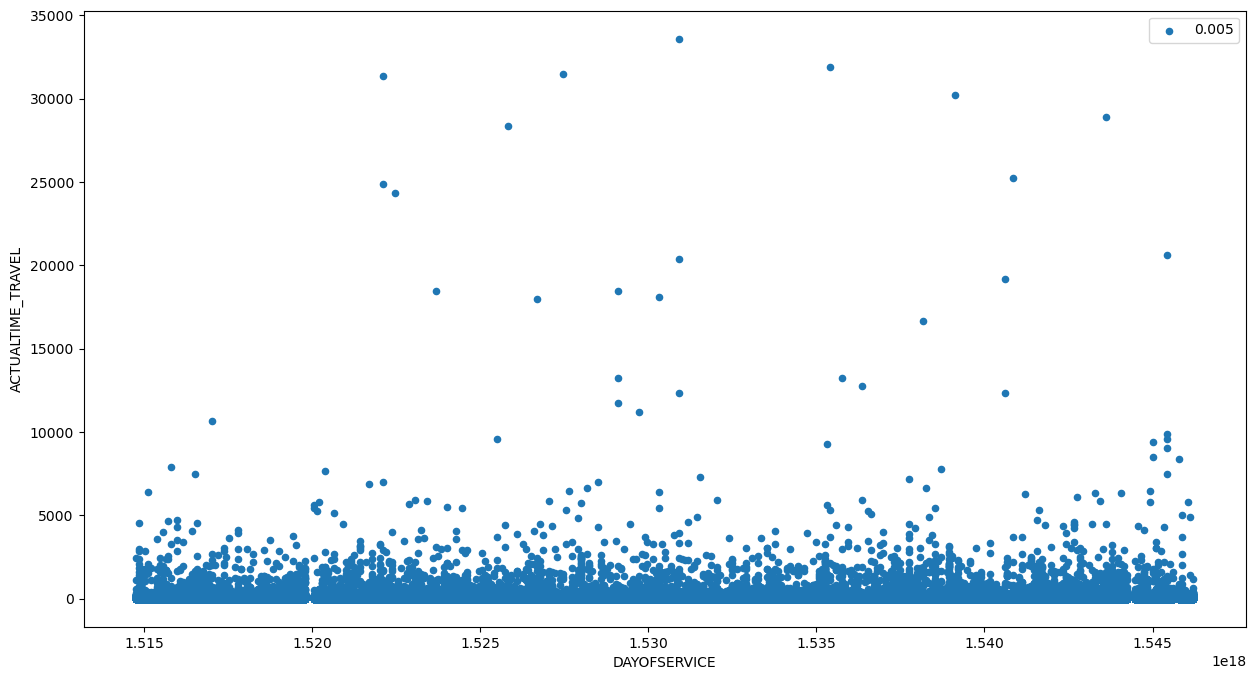

<Figure size 640x480 with 0 Axes>

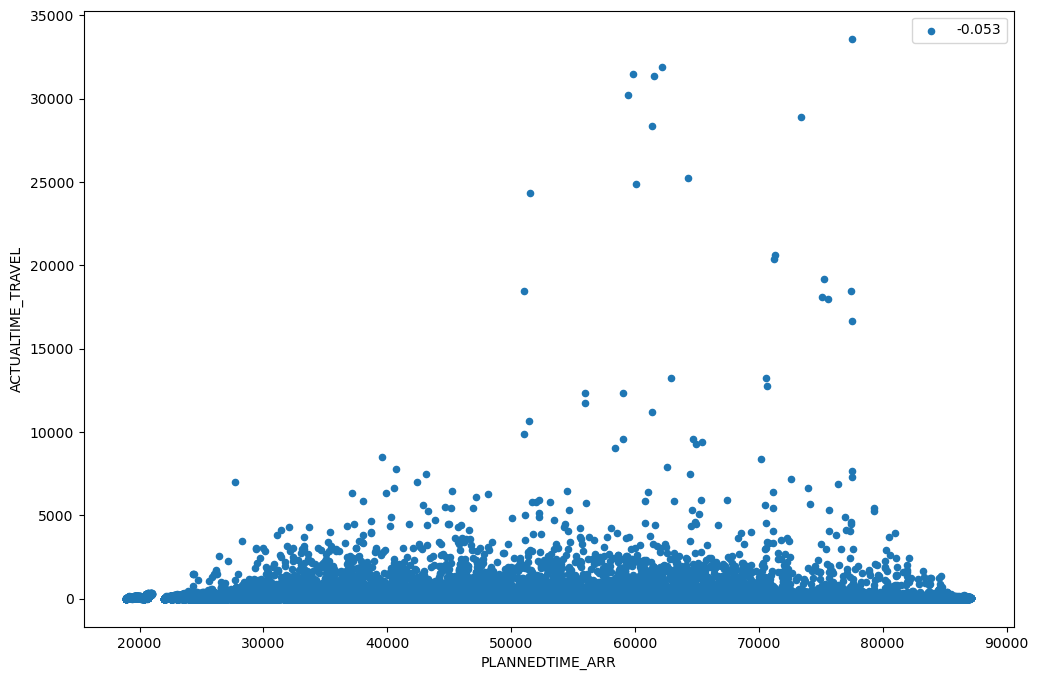

<Figure size 640x480 with 0 Axes>

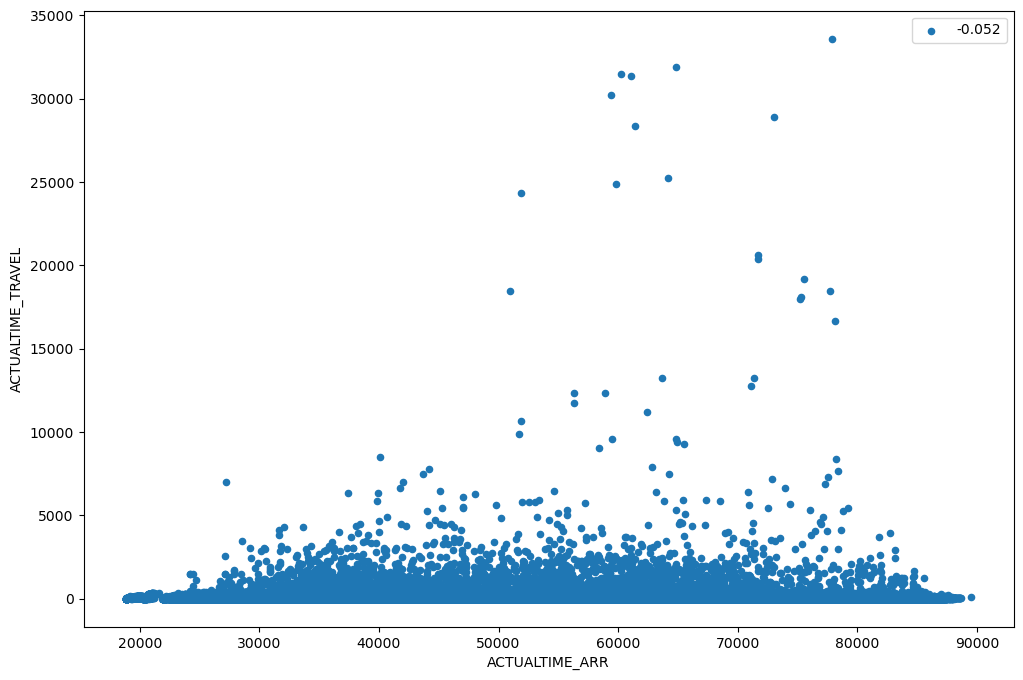

<Figure size 640x480 with 0 Axes>

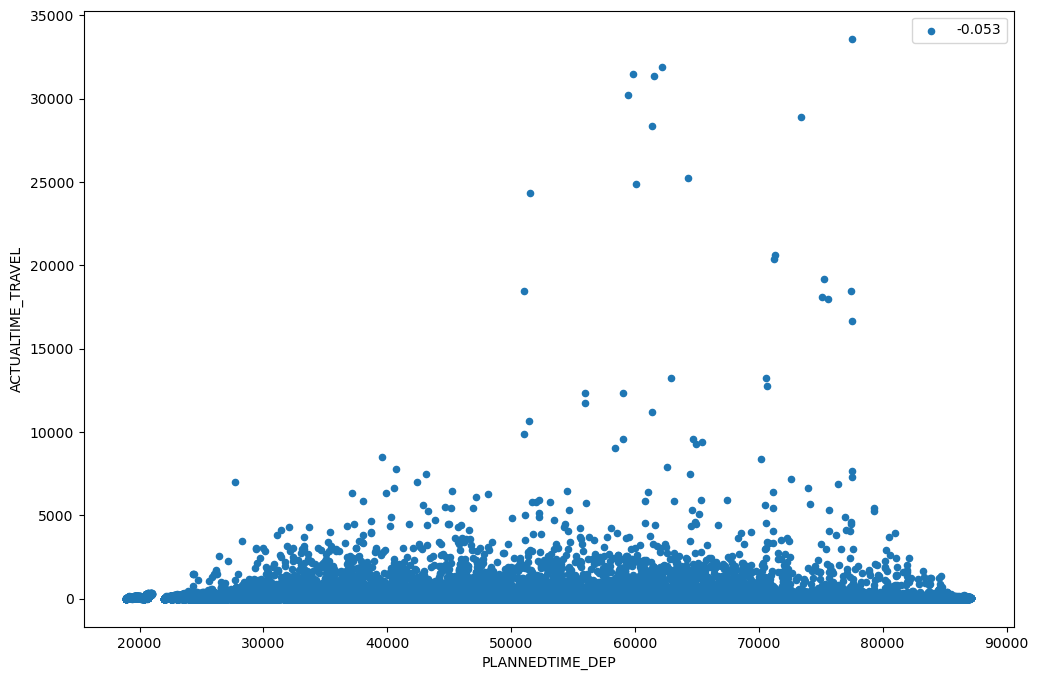

<Figure size 640x480 with 0 Axes>

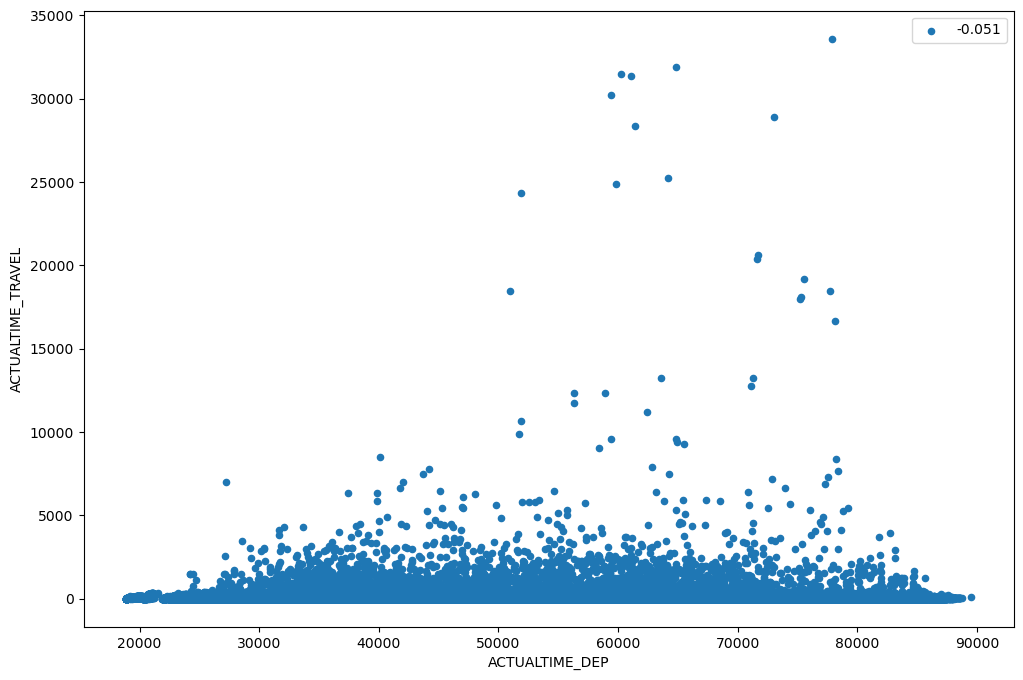

<Figure size 640x480 with 0 Axes>

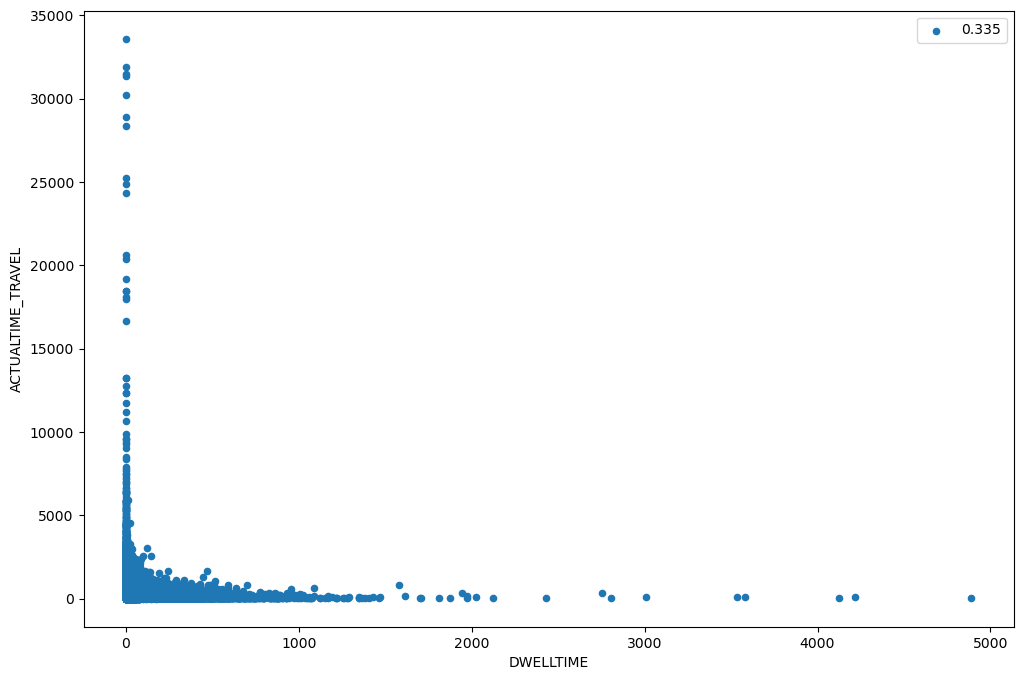

<Figure size 640x480 with 0 Axes>

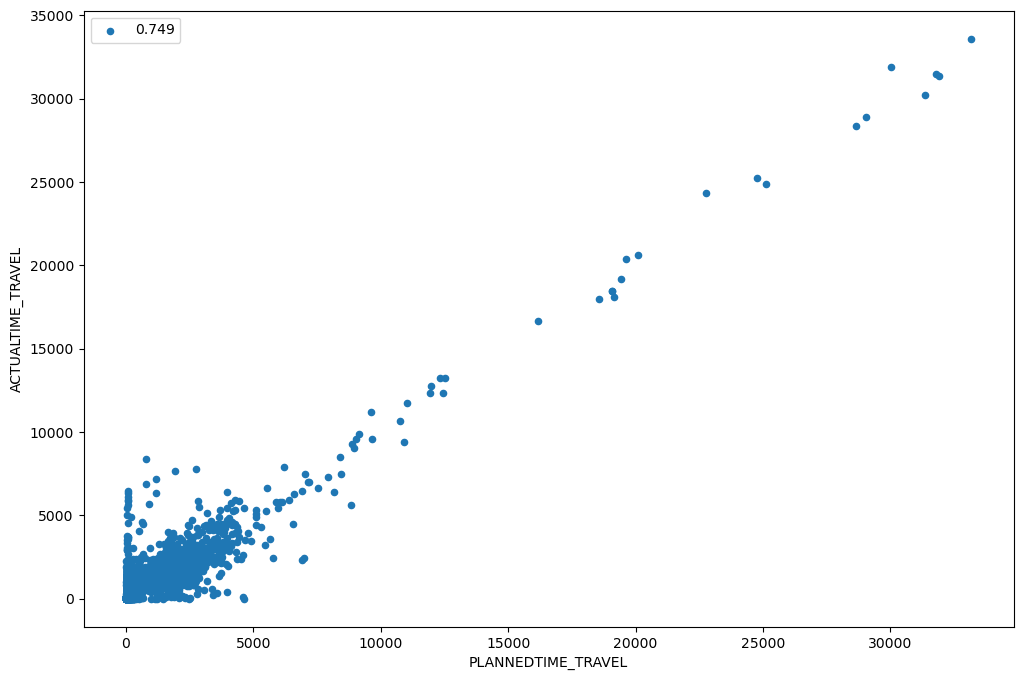

<Figure size 640x480 with 0 Axes>

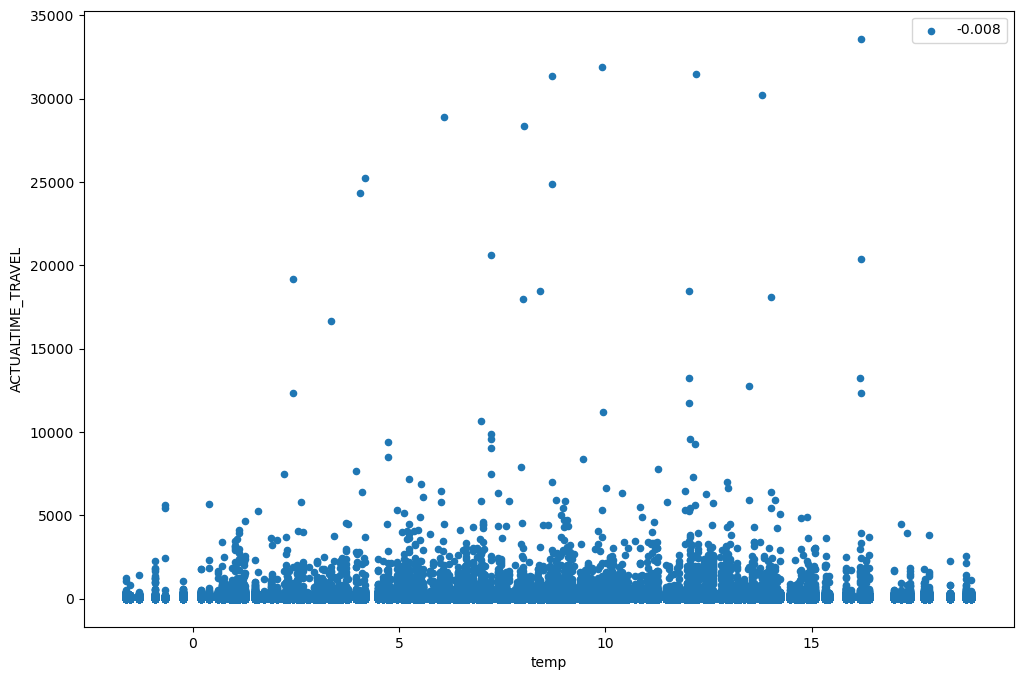

<Figure size 640x480 with 0 Axes>

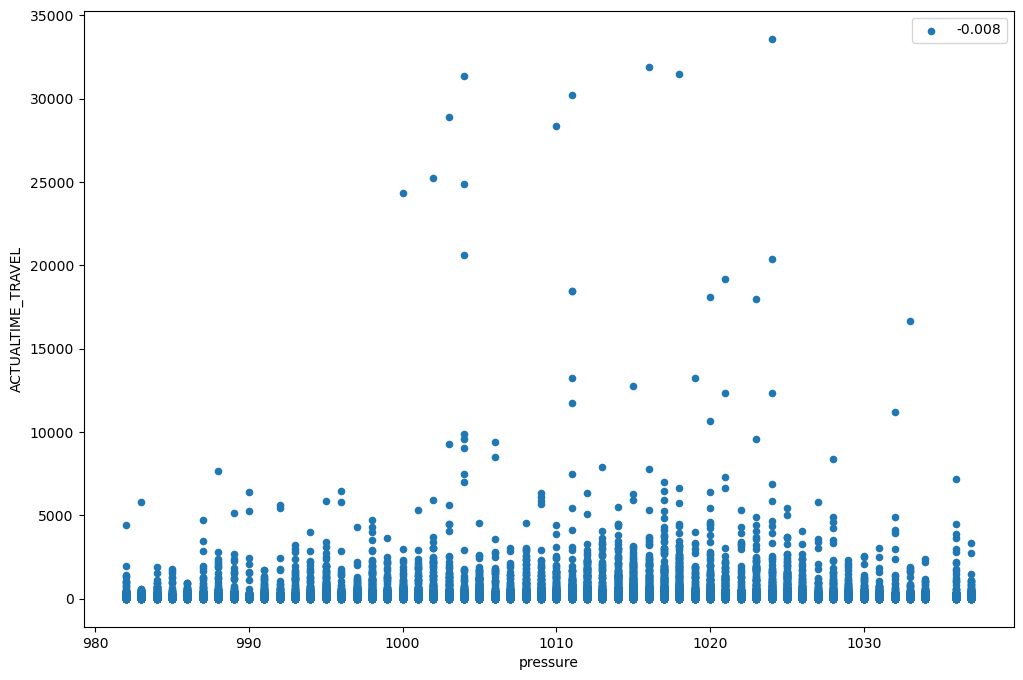

<Figure size 640x480 with 0 Axes>

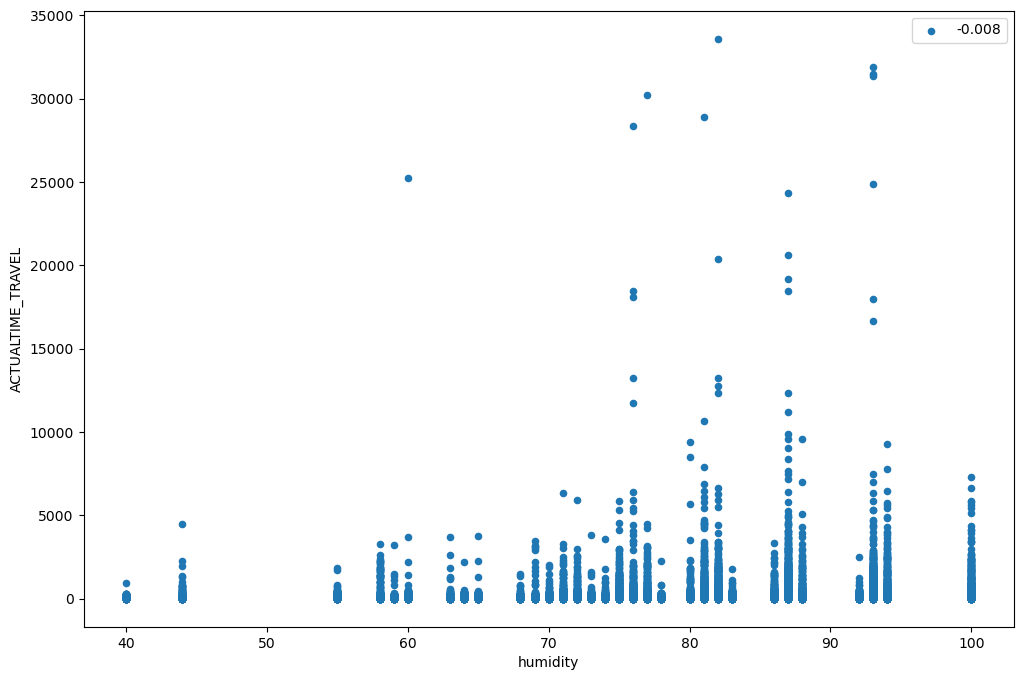

<Figure size 640x480 with 0 Axes>

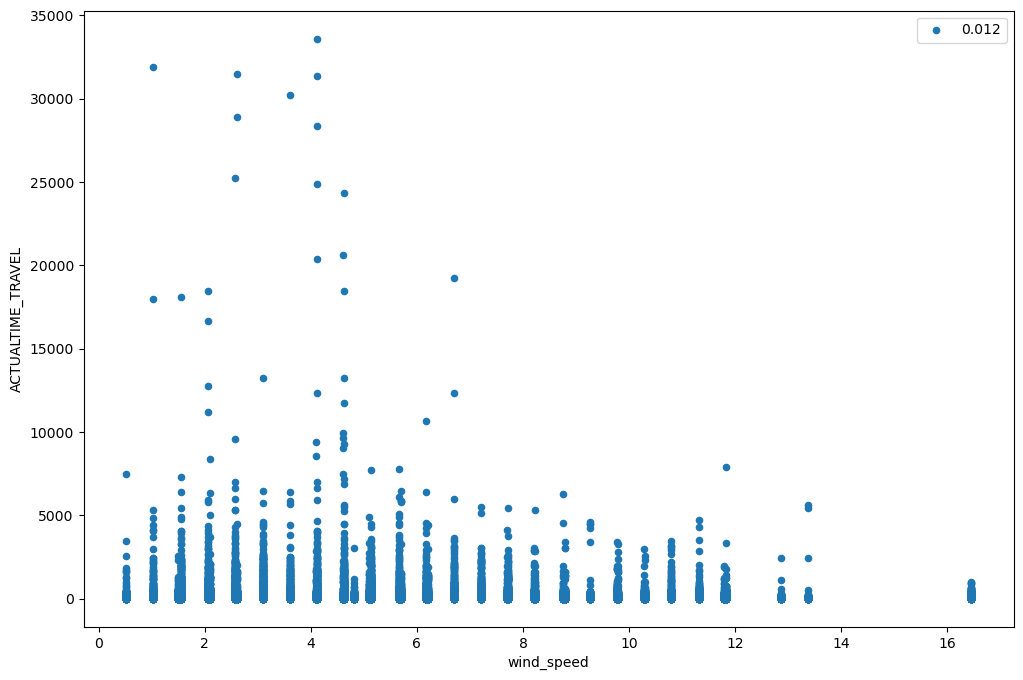

<Figure size 640x480 with 0 Axes>

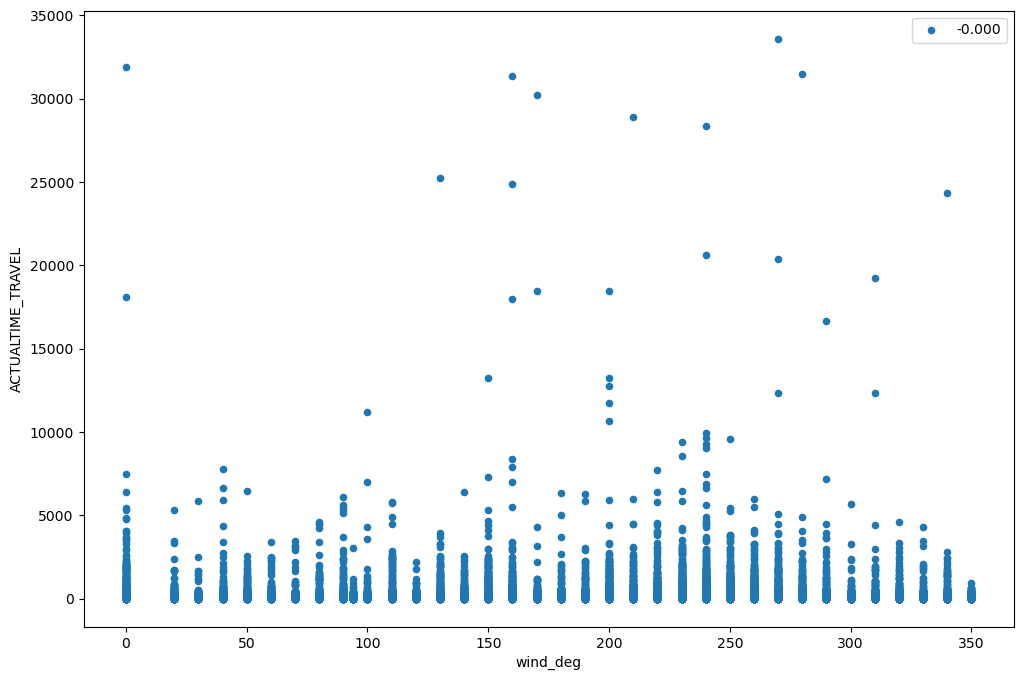

<Figure size 640x480 with 0 Axes>

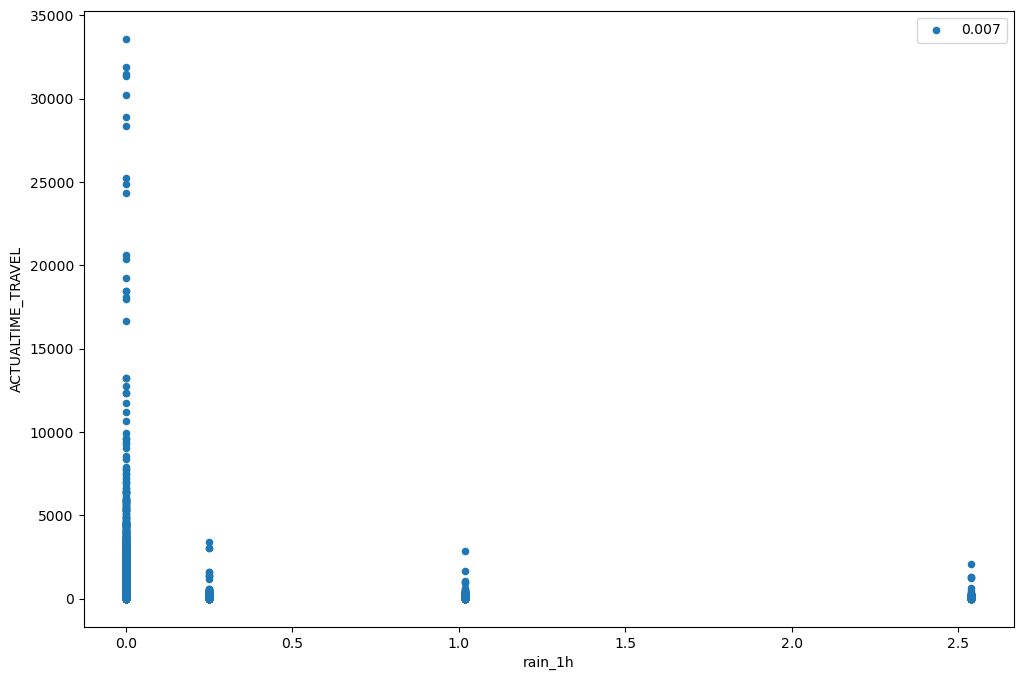

<Figure size 640x480 with 0 Axes>

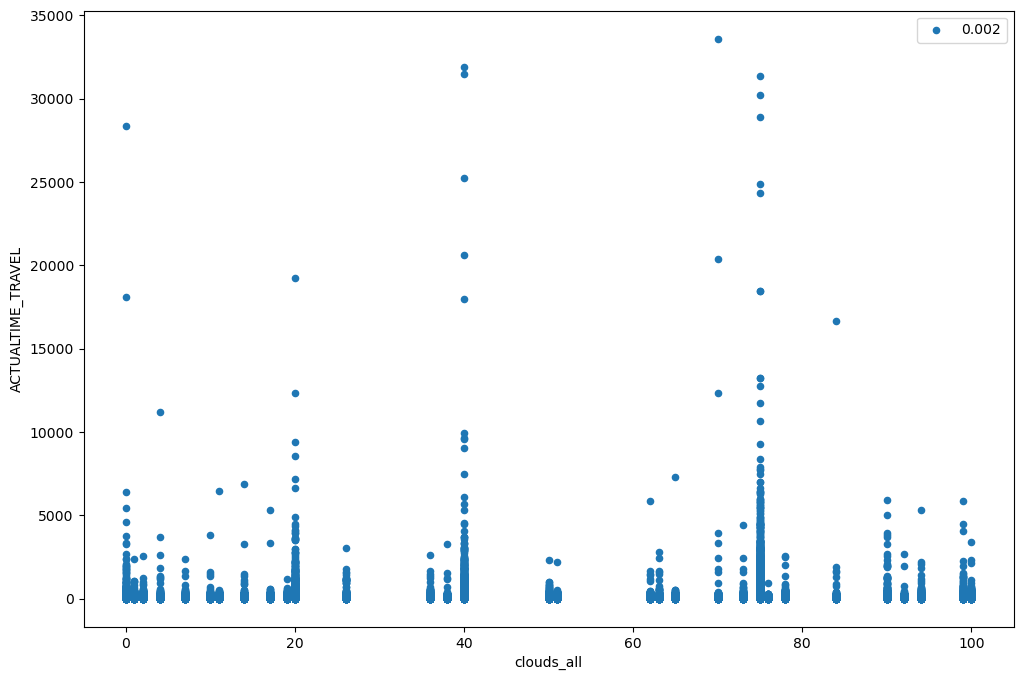

<Figure size 640x480 with 0 Axes>

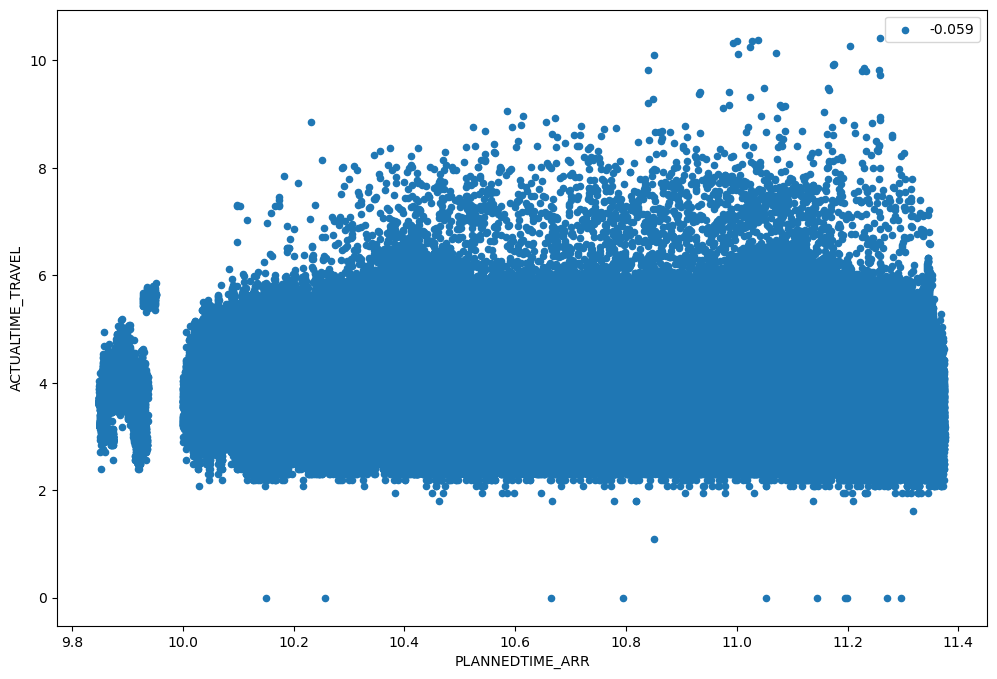

<Figure size 640x480 with 0 Axes>

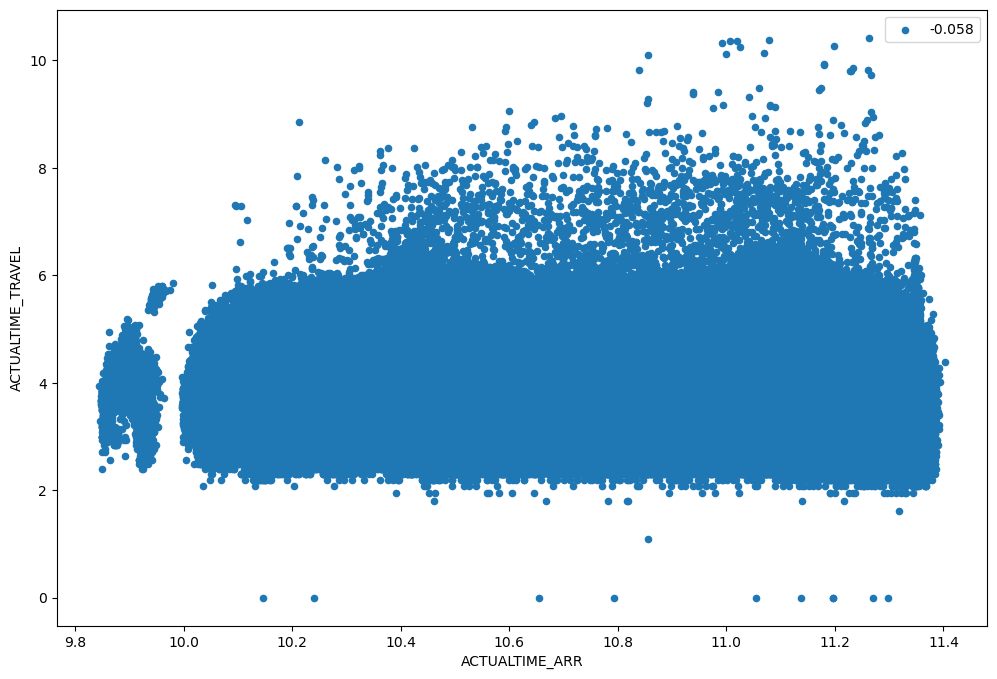

<Figure size 640x480 with 0 Axes>

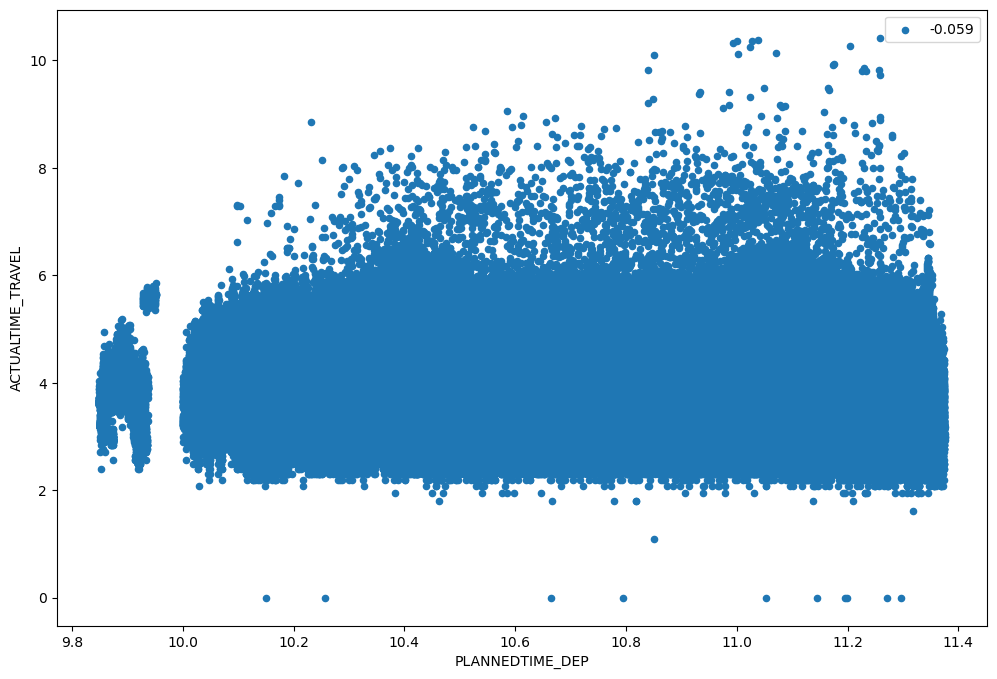

<Figure size 640x480 with 0 Axes>

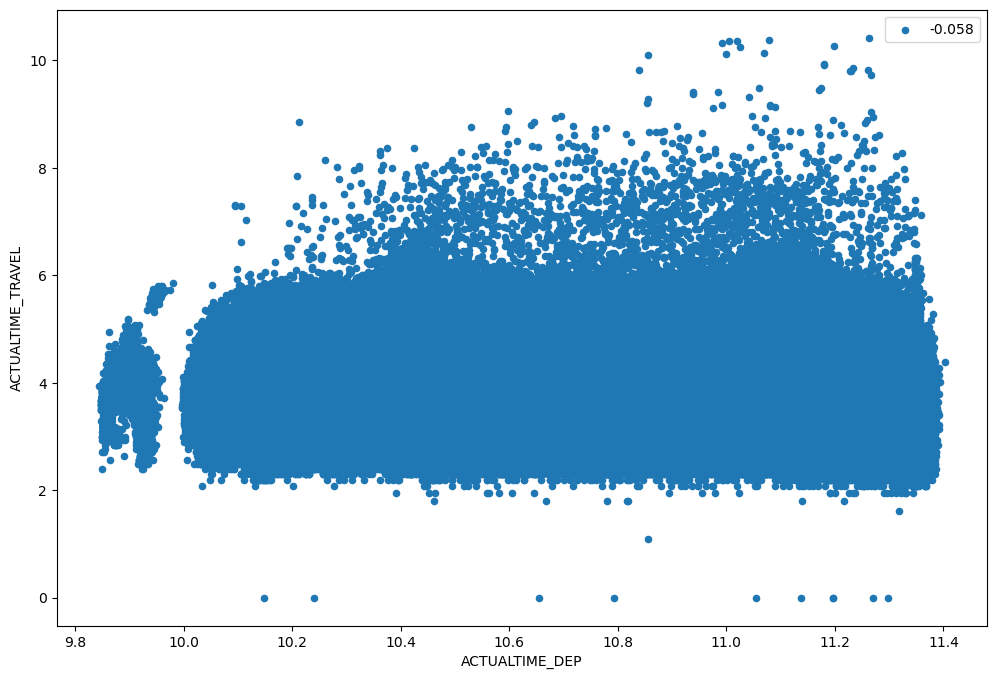

<Figure size 640x480 with 0 Axes>

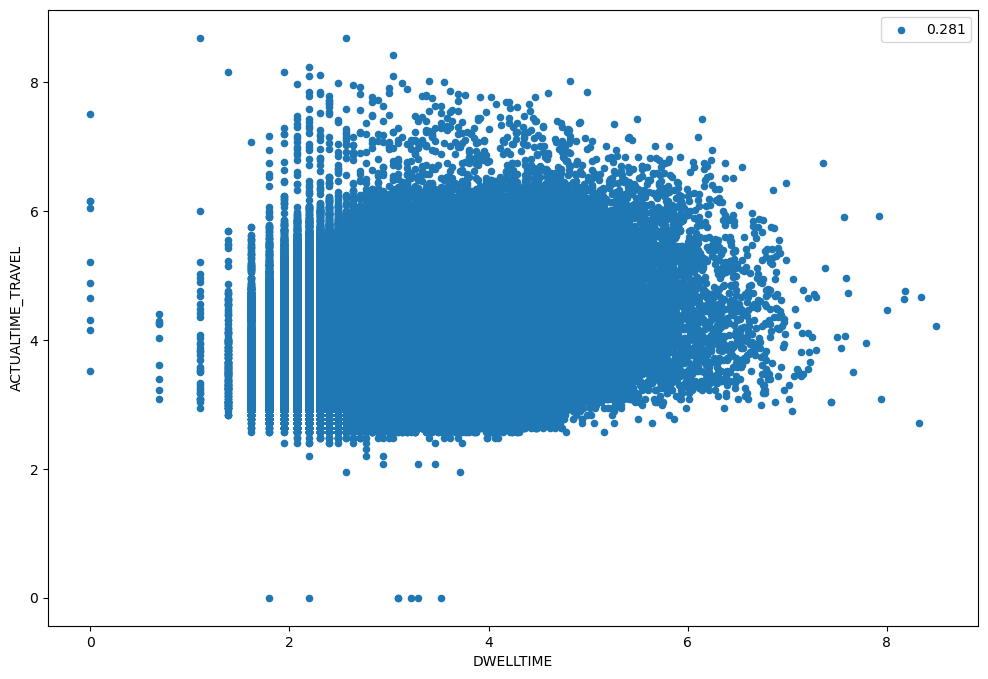

<Figure size 640x480 with 0 Axes>

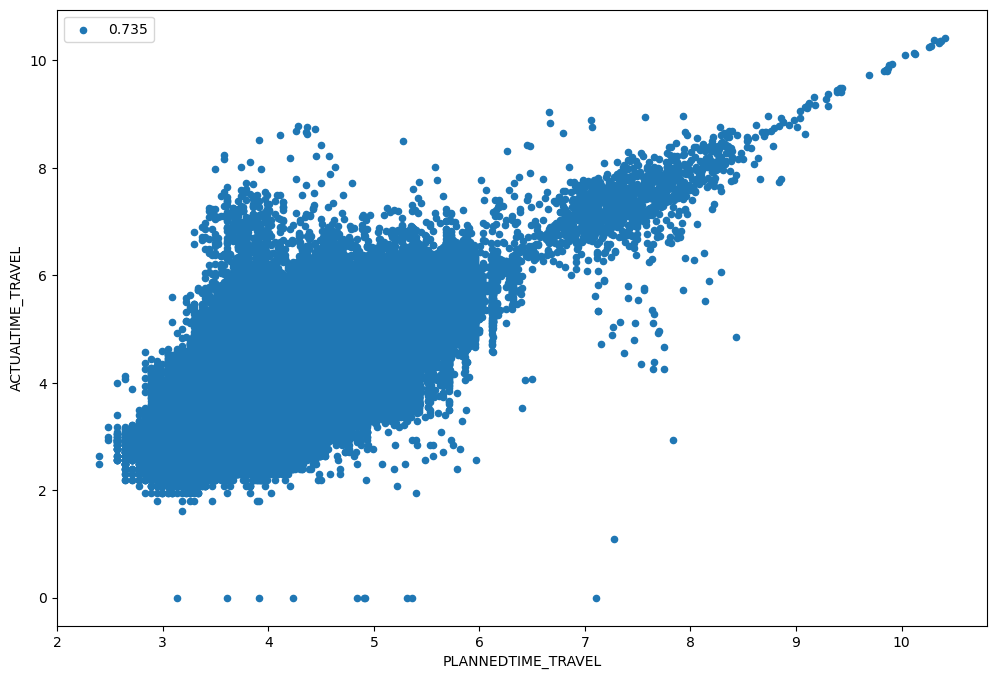

<Figure size 640x480 with 0 Axes>

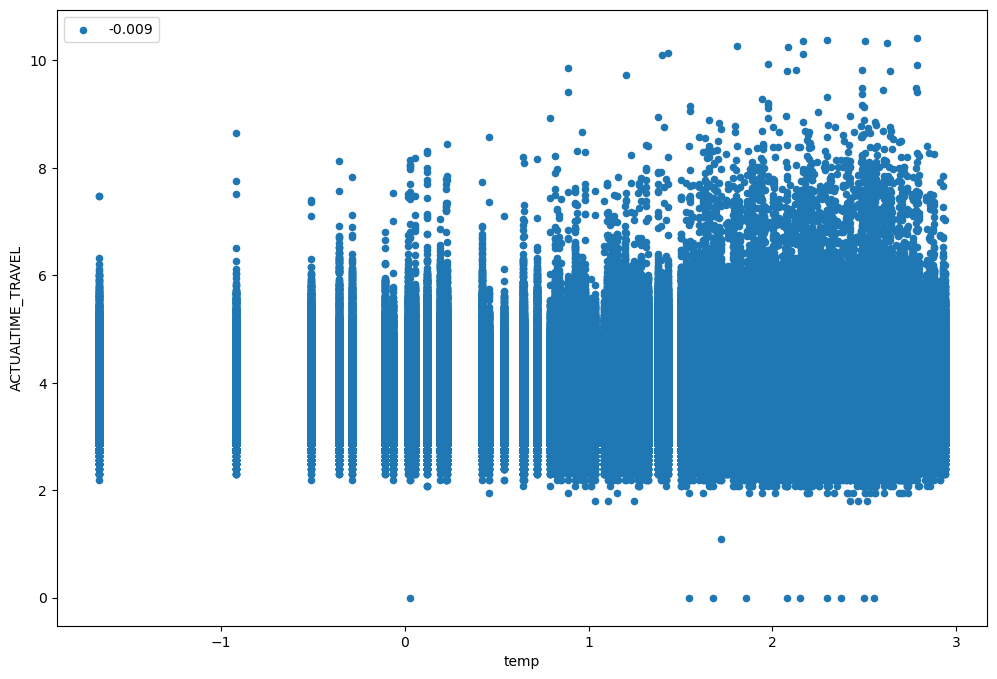

<Figure size 640x480 with 0 Axes>

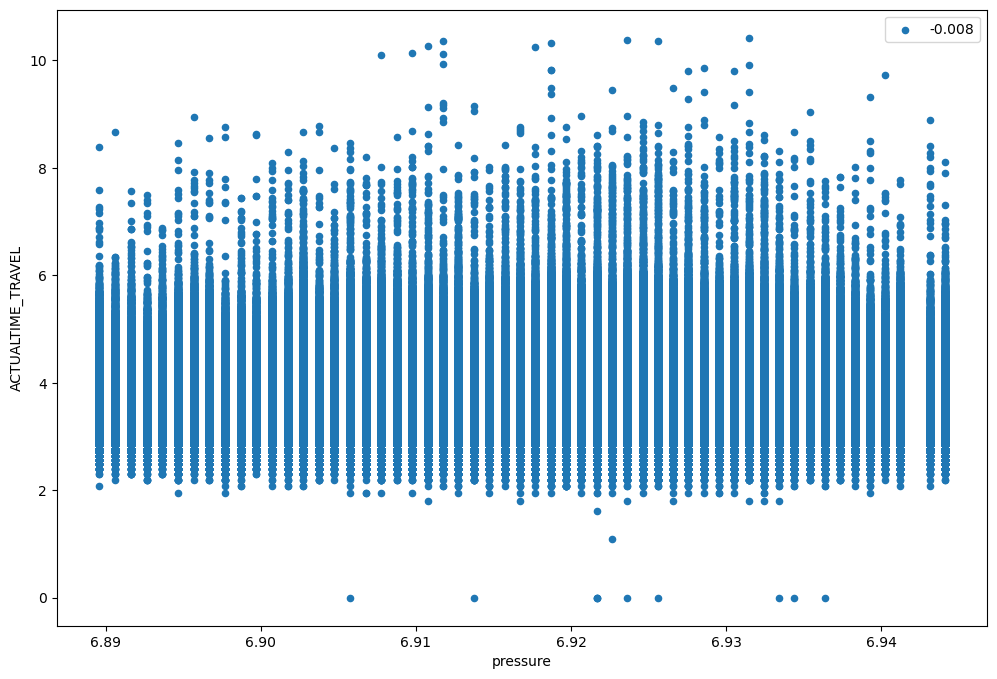

<Figure size 640x480 with 0 Axes>

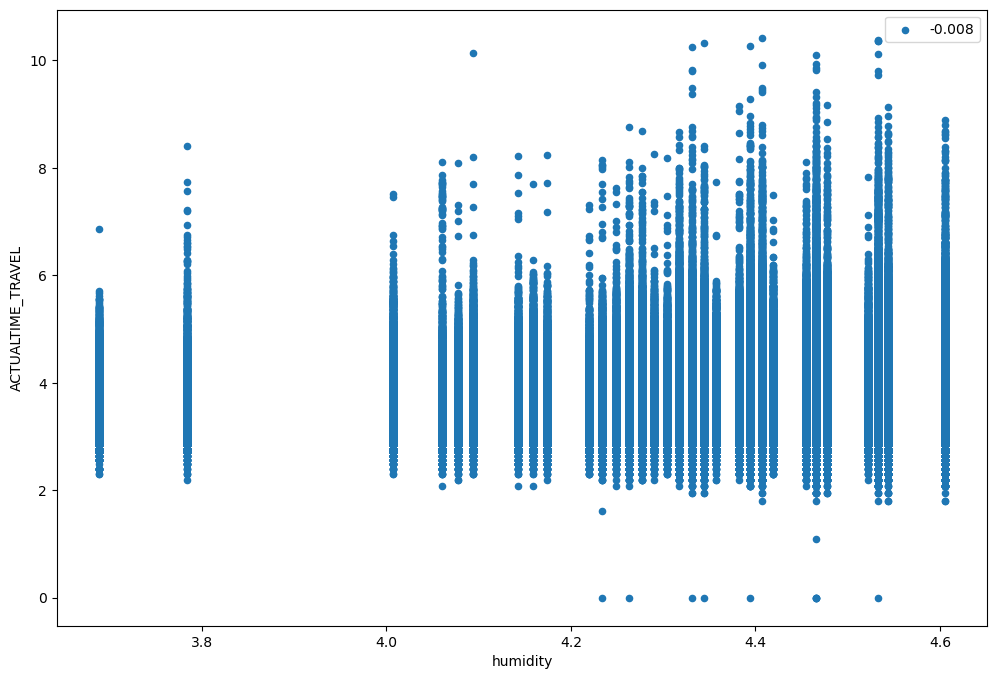

<Figure size 640x480 with 0 Axes>

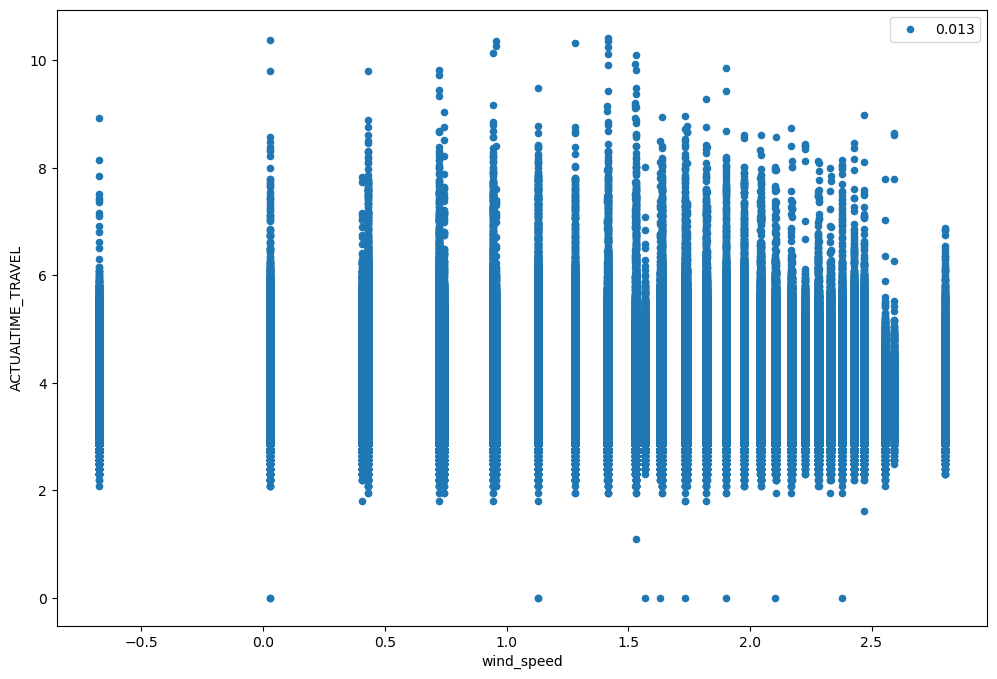

<Figure size 640x480 with 0 Axes>

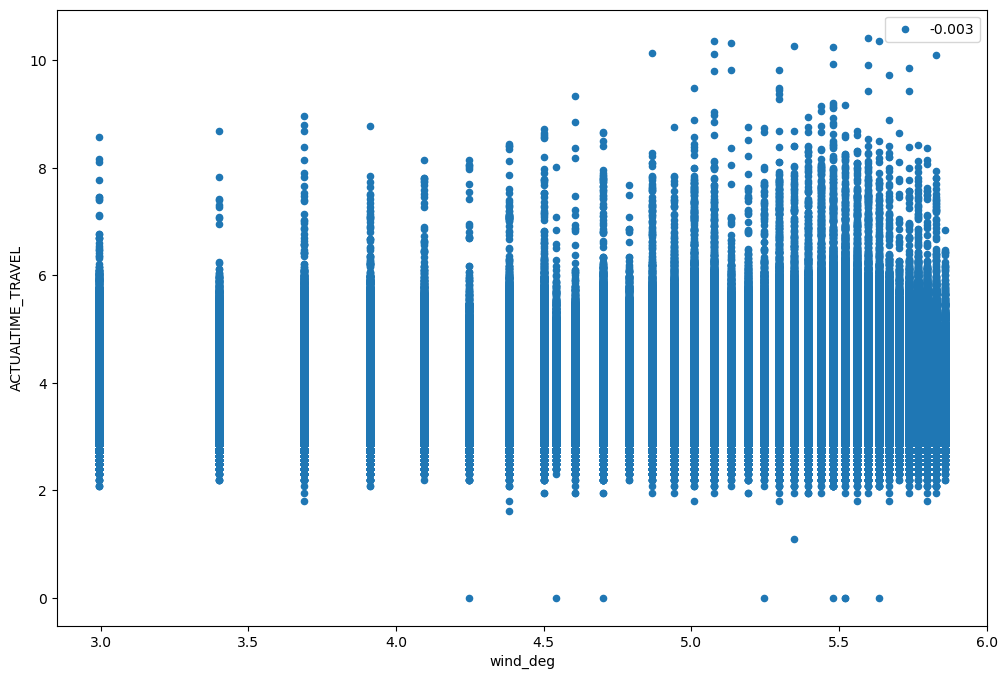

<Figure size 640x480 with 0 Axes>

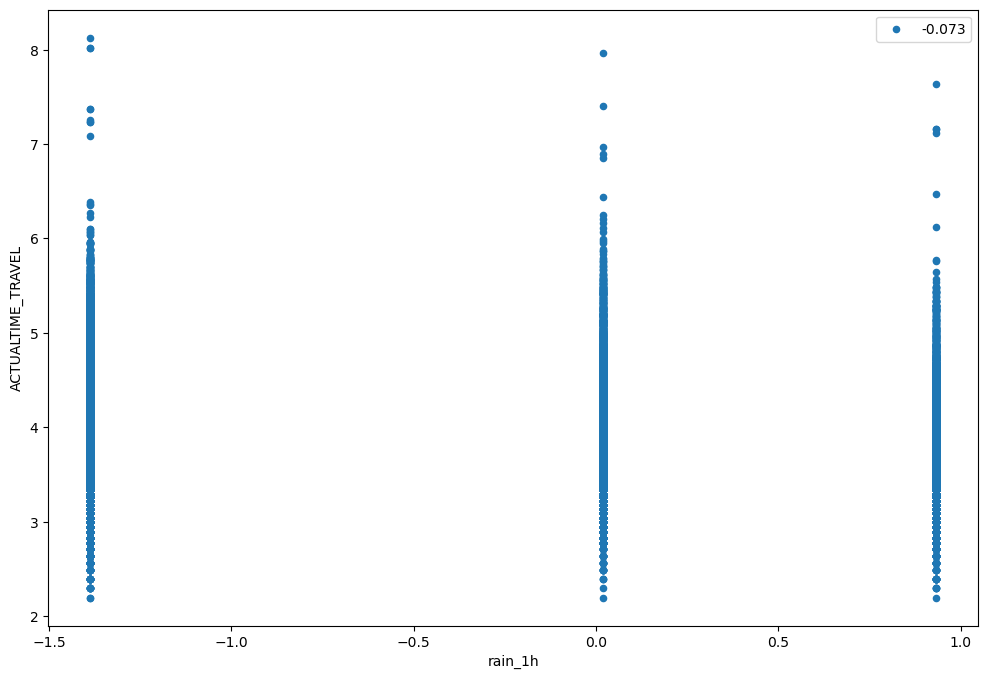

<Figure size 640x480 with 0 Axes>

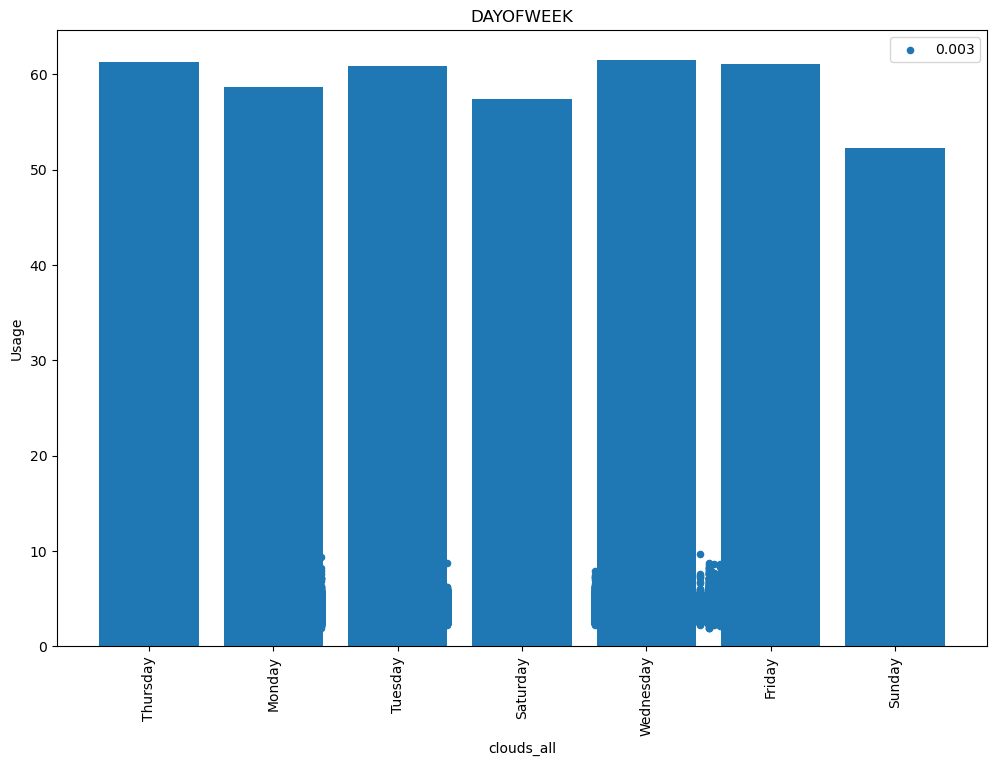

IS_HOLIDAY


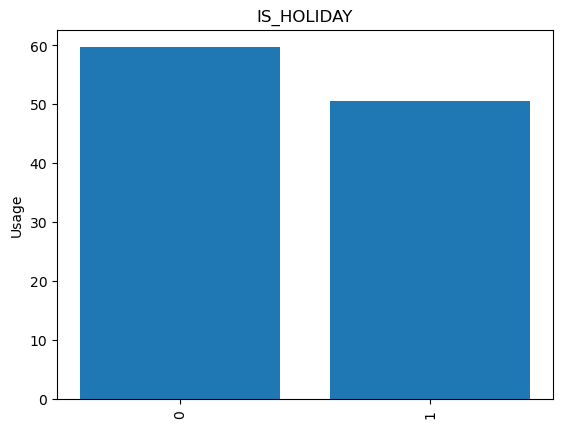

IS_WEEKDAY


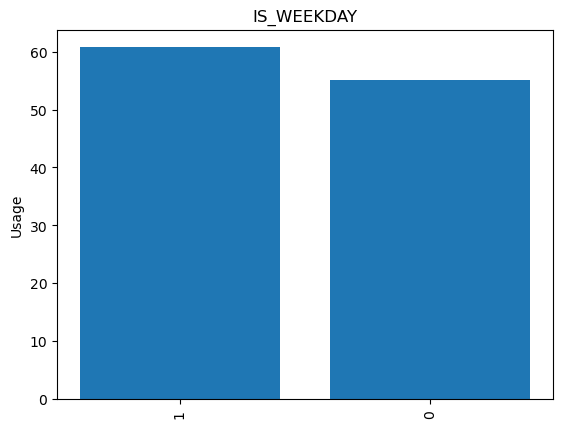

MONTHOFSERVICE


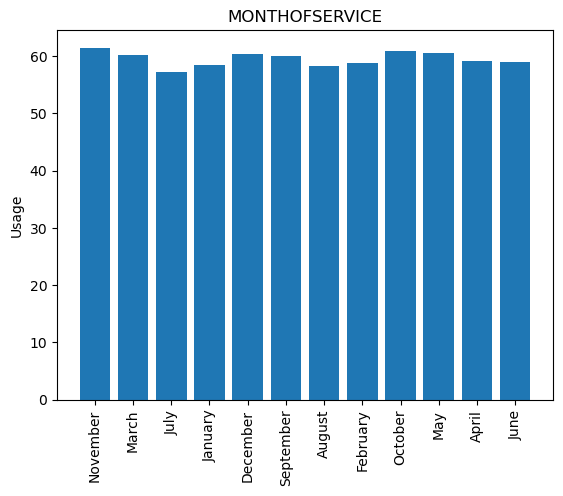

weather_id


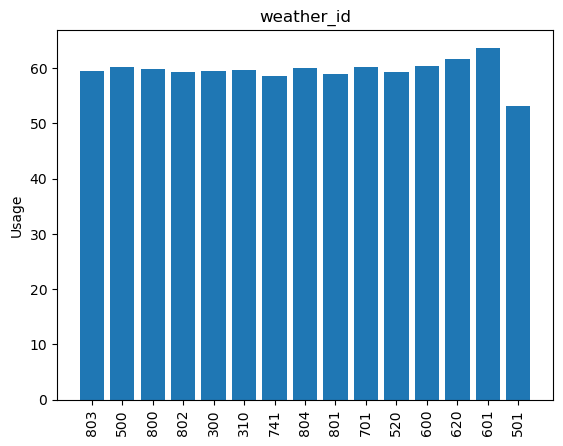

weather_main


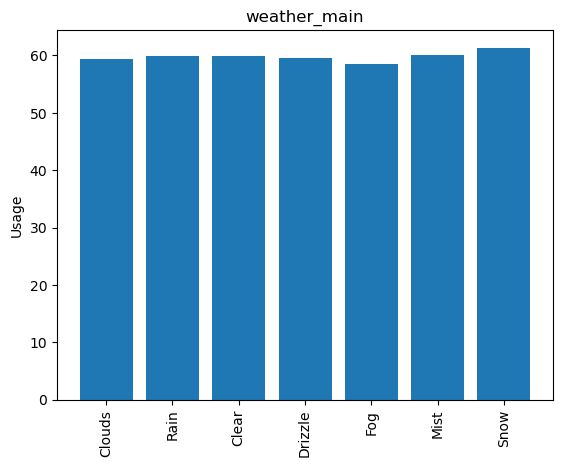

weather_description


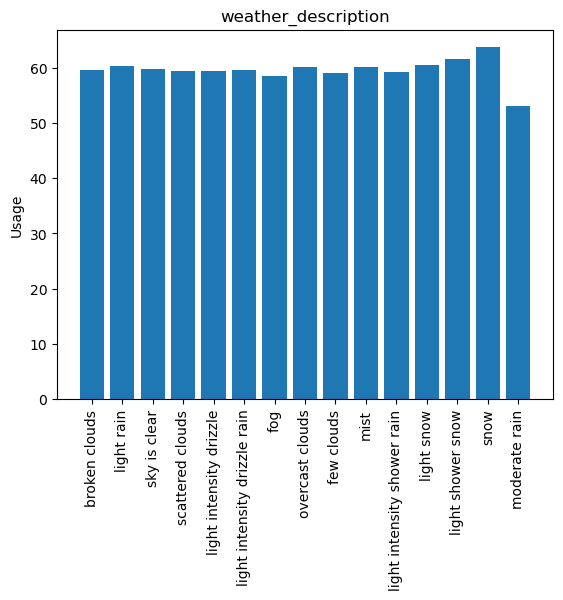

In [34]:
year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE', 'weather_id', 'weather_main', 'weather_description']

for feature in year_features:
    print(feature)
    df_temp = pd.concat([X_train, y_train], axis=1)
    unique = df_temp[feature].unique()
    list_average = []
    
    for value in unique:
        list_values = df_temp[df_temp[feature]== value]['ACTUALTIME_TRAVEL'].tolist()
        length_list = len(list_values)
        average =  sum(list_values)/length_list
        list_average += [average]
#         print(f'Sum of values / list of values: \n {sum(list_values)} / {length_list}')
#         print(f'Average ACTUALTIME_TRAVEL: {average}, \n')
        
    # taken from https://pythonspot.com/matplotlib-bar-chart/
    y_pos = np.arange(len(unique))
    plt.bar(y_pos, list_average, align='center')
    plt.xticks(y_pos, unique)
    plt.ylabel('Usage')
    plt.title(feature)
    plt.xticks(rotation=90)

    plt.show()

I think there is some outliers in ACTUALTME_TRAVEL. The averages are all in negatives which suggests that the travel times. Would that be an outlier if the negative values are very great? 
<br><br>
**DAYOFWEEK:**
The lowest average is Sunday and the busiest is Monday. So it does make a difference.
<br><br>
**IS_WEEKDAY:**
The same comment that there is a difference in average times.
<br><br>
**MONTHOFSERVICE:**
Interestingly enough, they have difference averages depending on each month with August being the least busiest and April being the busiest. It must have something to do with the weather maybe?


In [35]:
# Average time for each vehicle id
df_temp = pd.concat([X_train, y_train], axis=1)
vehicleid = df_temp['VEHICLEID'].unique().tolist()
for id_ in vehicleid:
    print(f'VEHICLEID: {id_}')
    list_values = df_temp[df_temp['VEHICLEID']== id_]['ACTUALTIME_TRAVEL'].tolist()
    length_list = len(list_values)
    average =  sum(list_values)/length_list
    print(f'Average ACTUALTIME_TRAVEL: {average} \n')

VEHICLEID: 2406879
Average ACTUALTIME_TRAVEL: 58.435411020776876 

VEHICLEID: 1000287
Average ACTUALTIME_TRAVEL: 60.91362878246366 

VEHICLEID: 1000293
Average ACTUALTIME_TRAVEL: 59.71228241532075 

VEHICLEID: 2693217
Average ACTUALTIME_TRAVEL: 52.90769230769231 

VEHICLEID: 1000290
Average ACTUALTIME_TRAVEL: 61.56415834522111 

VEHICLEID: 2172245
Average ACTUALTIME_TRAVEL: 61.478564500484964 

VEHICLEID: 1000284
Average ACTUALTIME_TRAVEL: 60.780944596467535 

VEHICLEID: 1000568
Average ACTUALTIME_TRAVEL: 60.58467070401211 

VEHICLEID: 1000278
Average ACTUALTIME_TRAVEL: 60.53091265947007 

VEHICLEID: 2172282
Average ACTUALTIME_TRAVEL: 60.979744525547446 

VEHICLEID: 1000269
Average ACTUALTIME_TRAVEL: 59.82044545525841 

VEHICLEID: 1000574
Average ACTUALTIME_TRAVEL: 60.934444444444445 

VEHICLEID: 2693271
Average ACTUALTIME_TRAVEL: 55.85776105362182 

VEHICLEID: 2693272
Average ACTUALTIME_TRAVEL: 56.0912822989616 

VEHICLEID: 1000576
Average ACTUALTIME_TRAVEL: 61.42638363040796 

VEHICL

Average ACTUALTIME_TRAVEL: 55.471881872447376 

VEHICLEID: 2868378
Average ACTUALTIME_TRAVEL: 56.22225642604279 

VEHICLEID: 2868381
Average ACTUALTIME_TRAVEL: 53.35860333438188 

VEHICLEID: 1932341
Average ACTUALTIME_TRAVEL: 60.948740512594874 

VEHICLEID: 2693280
Average ACTUALTIME_TRAVEL: 53.64355885078777 

VEHICLEID: 2534809
Average ACTUALTIME_TRAVEL: 58.21781055019853 

VEHICLEID: 2534854
Average ACTUALTIME_TRAVEL: 57.616793893129774 

VEHICLEID: 3265665
Average ACTUALTIME_TRAVEL: 52.42056364199443 

VEHICLEID: 2406865
Average ACTUALTIME_TRAVEL: 58.23590814196242 

VEHICLEID: 1932300
Average ACTUALTIME_TRAVEL: 62.37978196233895 

VEHICLEID: 3265670
Average ACTUALTIME_TRAVEL: 67.17686692869175 

VEHICLEID: 2693219
Average ACTUALTIME_TRAVEL: 60.45440906817803 

VEHICLEID: 3370459
Average ACTUALTIME_TRAVEL: 45.61212121212121 

VEHICLEID: 3265669
Average ACTUALTIME_TRAVEL: 55.893086816720256 

VEHICLEID: 1932340
Average ACTUALTIME_TRAVEL: 61.99585112873704 

VEHICLEID: 2406891
Averag

In [36]:
# Making dummy variables for categorical 
cat = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 'IS_HOLIDAY', 'IS_WEEKDAY', 'weather_id', 'weather_main', 'weather_description']
df_temp = pd.concat([X_train, y_train], axis=1)
df_copy = df_temp.copy()
df_copy = df_copy[cat]
df_copy = pd.get_dummies(df_copy)
df_copy = pd.concat([df_copy, y_train], axis=1)

categorical_corr = df_copy.corr()['ACTUALTIME_TRAVEL'][:]

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(categorical_corr)

DAYOFWEEK_Friday                                    0.005355
DAYOFWEEK_Monday                                   -0.002993
DAYOFWEEK_Saturday                                 -0.006114
DAYOFWEEK_Sunday                                   -0.019351
DAYOFWEEK_Thursday                                  0.006251
DAYOFWEEK_Tuesday                                   0.005113
DAYOFWEEK_Wednesday                                 0.007213
MONTHOFSERVICE_April                               -0.000897
MONTHOFSERVICE_August                              -0.003102
MONTHOFSERVICE_December                             0.001853
MONTHOFSERVICE_February                            -0.001955
MONTHOFSERVICE_January                             -0.002859
MONTHOFSERVICE_July                                -0.005298
MONTHOFSERVICE_June                                -0.001190
MONTHOFSERVICE_March                                0.001761
MONTHOFSERVICE_May                                  0.002393
MONTHOFSERVICE_November 

In [38]:
categorical_list = categorical_corr[categorical_corr > 0.04].index.tolist()
categorical_list.remove('ACTUALTIME_TRAVEL')

In [39]:
categorical_list

['PROGRNUMBER_13',
 'PROGRNUMBER_15',
 'PROGRNUMBER_16',
 'PROGRNUMBER_18',
 'PROGRNUMBER_50',
 'PROGRNUMBER_9',
 'STOPPOINTID_264',
 'STOPPOINTID_334',
 'STOPPOINTID_406',
 'STOPPOINTID_4565',
 'STOPPOINTID_747',
 'STOPPOINTID_81',
 'STOPPOINTID_842']

## 1.3. Summary of all features
<br><br>
#### Numerical Features
<br><br>

**DayOfService:**
* The correlation to the target feature is very low of 0.03806.
* Don't see it being a useful feature for the target feature. 
* Plot represents a straight line, which suggests little to no correlation.
* Conclusion: dropped because of the low correlation score. 

**PlannedTime_Arr:**
* There is very low correlation against the target feature though it gets better using spearman correlation.
* After logging the data, the correlation plot did not make a huge difference when using the spearman method to plot it for the second time. 
* Pearson and spearman plot pre log suggests little correlation as it is a continuous straight line. However, this shouldn't mean it should be dropped.
* When most values in the target feature fell less than 10, we see that the plannedtime arrival values increasing, it didn't change much. This would be due to the fact that the target feature is the difference between times so it would make sense that the relationship is poor.
* After logging the data, the plot is more spread out instead of a straight line, but the correlation score still shows a similar low score with a .02 difference using the spearman method. 
* Conclusion: However, this will not be dropped because having information about the planned time arrival can influence the target feature. 

**ActualTime_Arr:**
* Compared to Planned time arrival feature, the pearson correlation score is poorer but the spearman scores are more similar pre log. 
* It is similar to planned time arrival in that the plot represents a straight line, that suggests a poor relationship with the target feature. 
* After logging the data, it is found that the plot is more spread out. The score using spearman is not much different pre logging the data. 
* However, it would be unwise to drop this feature as it I feel it would serve good purpose for the target feature for predicting the prediction time for the next stop. 
* Conclusion: this will not be dropped.

**PlannedTime_Dep:**
* Planned time departure has little correlation with the target feature after looking at spearman and pearsons. 
* It doesn't have a linear relationship and the straight line on the plot of both methods proves this.
* However, when plotted using the logged values we see that the correlation score hasn't changed but the data is more spread out. 
* This doesn't change the relationship much, however. 
* Even so, this will be kept as I feel it would help the predictions. Having the planned time departures would help skew a better result because it would relatively be close to the actual time departure even though it is just an estimate.
* Conclusion: this will not be dropped as it will still serve to be a useful feature for predicting a time in seconds. 

**ActualTime_Dep:**
* Actual time departure is again, more or less the same. It represents the departure for these times at a particular stop to go to the next stop. It is strange that the correlation is so low even after logging the data but it would make sense as you wouldn't expect there to be a linear relationship.
* The plot is similar to the rest of the previous features mentioned so far. 
* However, it will still be kept because I feel it would still be a useful feature for predicting a time in seconds. 
* By taking the actual time departure for a particular stop it may help.
* Conclusion: this will not be dropped as it may prove to be useful.

**Dwell Time:**
* Dwell time has a 0.03 coorelation score with the target feature. It suggests on the graph that the time for dwell time equal to 0 then the more the target feature time increases. It might suggest traffic times where if a bus is full then it might be due to rush hour? busy hours?
* Plotting against the target feature after logging the data gives similar scores using the spearman correlation method. However we see the graph differing from pre log plot. It is more grouped up together compared to the previous graph plot.
* Because the score is more fairer compared to the previous, it will be useful to keep it for the modelling.
* Conclusion: Keep.

**PlannedTime_Travel:**
* When plotting using the pearse correlation method, it gave a correlation of 0.2. This time it is the highest correlation and we see a small linear relationship.
* The time for planned time travel, as it increases, so does the target feature. It gives us an indication of that slight linear relationship.
* Using spearmans to graph the correlation gave us a 0.7 score which is a good indication that the two features has a linear relationship.
* Because of this, this feature will be kept.

**Temp:**
* Temp  has a negative 0.009 correlation with the target feature and an even poorer linear relationship at -.002.
* This indicates a poor linear/monotonic relationship and it will not serve useful for the model.
* The graph plots does not give anymore useful information that would give further evidence that it should be kept.
* Conclusion: drop.

**Pressure:**
* It also has a negative linear relationship with the target feature.
* When looking at the graph plots for both spearman and pearsons, it does not give any further insights.
* For this reason, this feature will be dropped.

**Humidity:**
* Humidity does not have a strong relationship with the target feature, be it linear or monotonic.
* The reason being the correlation using both methods fell < 0.00. 
* Unfortunately, the graph does not represent anything useful either.
* When looking at the logged data plots however, there is a slight difference however it is not signficant enough that this feature should still be kept as there is no distinct relationship that we can see.
* Conclusion: drop.

**Windspeed:**
* No linear relationship.
* Indicates a small monotonic relationship.
* This means that as the windspeed value increases, the value of the target feature tends to be higher as well.
* But a spearman correlation of 0.01 is not strong enough of a feature to keep.
* Conclusion: drop

**Wind_Deg:**
* This feature will be dropped immediately as the correalations are both <0.000.

**Rain_1H:**
* It doesn't have a strong linear relationship but it shows spearmans correlation some promising results when the data has been logged.


<br><br>
#### Categorical Features
<br><br>
**DayOfWeek:**
* In the graph we see the actual time travel increasing during weekdays and slowly the travel time is less during weekends. 
* This suggests a relationship between the days of the week and the target feature in which weekdays have a higher tendency for the actualtime travel feature to be higher.
* Conclusion: this will be kept.

**MonthofService:**
* In the graph, we don't really see a connection between each month against the target feature even if it is in order. 
* The overall actual travel time is higher in february before it dips, then rising during winter season.
* The correlation score seems to be poor also for each month. 
* This feature will still be kept. 

**Progrnumber:**
* Most progrnumbers will be dropped as a lot of the correlations are <0.00.
* For this reason, this feature will be dropped.
    
**StoppointID:**
* Similarly to progrnumbers, there are a lot of low correlations falling <0.00.
* Most stoppoint numbers are <0.00 correlation.
* This indicates a very low relationship with the target feature. 
* For this reason, this feature will be dropped, except for those with a correlation > 0.04
    
**Is_Holiday:**
* After analyzing the graph, we see a relationship between the target feature and whether or not the time falls under a holiday date (non-school holiday).
* If it a non holiday, the actual time travel increases. 
* If it is a holiday, the actual time travel decreases. 
* This means that less people are using public transport if it is a holiday date.
* For this reason, this feature will be kept.

**Is_Weekday:**
* Like Is_Holiday, we see a relationship between the target feature and whether or not the time is during a weekday or not. 
* We see a contrast between the two values in which 1, being a weekday, has a higher actual time travel, vice versa.
* For this reason, it is a good indication of a relationship to the target feature.
* Therefore, this feature will be kept. 

**VehicleID:**
* When looking at the different averages, we see that the average differences are not big.
* For this reason, it may be best to drop this feature because it doesn't give any indication it would be a useful feature to help the prediction models.


## 1.4 Cleaning up features

### Setting low correlation features - keep

In [40]:
# Numerical features
low_corr_numerical = ['PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP']

# Categorical features
low_corr_categorical = ['DAYOFWEEK', 'MONTHOFSERVICE', 'IS_HOLIDAY', 'IS_WEEKDAY'] + categorical_list

### Setting low correlation features - drop

In [41]:
low_corr = ['DAYOFSERVICE', 'VEHICLEID', 'TRIPID', 'STOPPOINTID', 'PROGRNUMBER', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id', 'weather_description', 'clouds_all']

### Setting high correlation  features

In [42]:
# Numerical features 
high_corr_numerical = ['DWELLTIME', 'PLANNEDTIME_TRAVEL']

### Dropping features & setting dummy features

In [43]:
df_copy = df.copy()
df_copy = df_copy.drop(low_corr, 1)
df_copy

,DAYOFWEEK,MONTHOFSERVICE,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY,rain_1h,weather_main
0,Saturday,January,36000,35983,36000,35983,0,0,0,0,0,0.0,Clouds
1,Saturday,January,36078,36011,36078,36011,0,78,28,0,0,0.0,Clouds
2,Saturday,January,36124,36027,36124,36038,11,46,16,0,0,0.0,Clouds
3,Saturday,January,36197,36094,36197,36094,0,73,56,0,0,0.0,Clouds
4,Saturday,January,36242,36186,36242,36214,28,45,92,0,0,0.0,Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164838,Sunday,December,79817,80067,79817,80067,0,29,13,0,0,0.0,Clouds
2164839,Sunday,December,79834,80083,79834,80089,6,17,16,0,0,0.0,Clouds
2164840,Sunday,December,79875,80142,79875,80142,0,41,53,0,0,0.0,Clouds
2164841,Sunday,December,79907,80200,79907,80200,0,32,58,0,0,0.0,Clouds


In [44]:
df_copy = pd.get_dummies(df_copy)
df_copy

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
0,36000,35983,36000,35983,0,0,0,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,36078,36011,36078,36011,0,78,28,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,36124,36027,36124,36038,11,46,16,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,36197,36094,36197,36094,0,73,56,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,36242,36186,36242,36214,28,45,92,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164838,79817,80067,79817,80067,0,29,13,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
2164839,79834,80083,79834,80089,6,17,16,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
2164840,79875,80142,79875,80142,0,41,53,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0
2164841,79907,80200,79907,80200,0,32,58,0.0,0,0,...,0,1,0,0,1,0,0,0,0,0


### Training & Testing data

In [45]:
# All features
features = df_copy.columns.tolist()
features

['PLANNEDTIME_ARR',
 'ACTUALTIME_ARR',
 'PLANNEDTIME_DEP',
 'ACTUALTIME_DEP',
 'DWELLTIME',
 'PLANNEDTIME_TRAVEL',
 'ACTUALTIME_TRAVEL',
 'rain_1h',
 'DAYOFWEEK_Friday',
 'DAYOFWEEK_Monday',
 'DAYOFWEEK_Saturday',
 'DAYOFWEEK_Sunday',
 'DAYOFWEEK_Thursday',
 'DAYOFWEEK_Tuesday',
 'DAYOFWEEK_Wednesday',
 'MONTHOFSERVICE_April',
 'MONTHOFSERVICE_August',
 'MONTHOFSERVICE_December',
 'MONTHOFSERVICE_February',
 'MONTHOFSERVICE_January',
 'MONTHOFSERVICE_July',
 'MONTHOFSERVICE_June',
 'MONTHOFSERVICE_March',
 'MONTHOFSERVICE_May',
 'MONTHOFSERVICE_November',
 'MONTHOFSERVICE_October',
 'MONTHOFSERVICE_September',
 'IS_HOLIDAY_0',
 'IS_HOLIDAY_1',
 'IS_WEEKDAY_0',
 'IS_WEEKDAY_1',
 'weather_main_Clear',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Fog',
 'weather_main_Mist',
 'weather_main_Rain',
 'weather_main_Snow']

In [46]:
datas = {'ACTUALTIME_TRAVEL': df_copy['ACTUALTIME_TRAVEL']}
y = pd.DataFrame(data=datas)
X = df_copy.drop(['ACTUALTIME_TRAVEL'],1)

In [47]:
# Splitting the dataset into 2 datasets: 
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("The Original range of the dataset: ",df.shape[0])
print("The Training range taken from dataset: (70%): rows 0 to", round(X_train.shape[0]))
print("The Test range taken from dataset: (30%): rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The Original range of the dataset:  2164843
The Training range taken from dataset: (70%): rows 0 to 1515390
The Test range taken from dataset: (30%): rows 1515390 to 2164843


In [48]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
          PLANNEDTIME_ARR  ACTUALTIME_ARR  PLANNEDTIME_DEP  ACTUALTIME_DEP  \
1890841            24212           24415            24212           24430   
440267             71409           71441            71409           71453   
1381118            70248           70502            70248           70520   
75522              42050           41811            42050           41819   
1111331            57986           58005            57986           58005   

         DWELLTIME  PLANNEDTIME_TRAVEL  rain_1h  DAYOFWEEK_Friday  \
1890841         15                  67      0.0                 0   
440267          12                  59      0.0                 0   
1381118         18                  61      0.0                 0   
75522            8                 108      0.0                 0   
1111331          0                  86      0.0                 0   

         DAYOFWEEK_Monday  DAYOFWEEK_Saturday  ...  IS_HOLIDAY_1  \
1890841                 0

In [49]:
# I will reset the indexes of the training and test splits so we can see the X_train printout
# We will see that they are no longer in order and the next markdown cell I will reset the indexes.
X_train.head(5)

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,DAYOFWEEK_Saturday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
1890841,24212,24415,24212,24430,15,67,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
440267,71409,71441,71409,71453,12,59,0.0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1381118,70248,70502,70248,70520,18,61,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
75522,42050,41811,42050,41819,8,108,0.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1111331,57986,58005,57986,58005,0,86,0.0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [50]:
# Using .reset_index 
# We see that they are in order again. 
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(10)

,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,rain_1h,DAYOFWEEK_Friday,DAYOFWEEK_Monday,DAYOFWEEK_Saturday,...,IS_HOLIDAY_1,IS_WEEKDAY_0,IS_WEEKDAY_1,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Mist,weather_main_Rain,weather_main_Snow
0,24212,24415,24212,24430,15,67,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,71409,71441,71409,71453,12,59,0.0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2,70248,70502,70248,70520,18,61,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,42050,41811,42050,41819,8,108,0.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,57986,58005,57986,58005,0,86,0.0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
5,58321,58403,58321,58433,30,44,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6,39782,39870,39782,39885,15,84,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
7,40282,41020,40282,41020,0,41,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,65171,65844,65171,65844,0,87,0.0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
9,81486,81834,81486,81881,47,86,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


# 2. Linear Regression

In this section, I will be preparating a linear regression model. I will attempt to see the prediction overall.

## 2.1 Training a linear regression model to predict the target feature.

In [51]:
linear_reg = LinearRegression().fit(X_train, y_train)

## 2.2 Printing out the coefficients learned by the model and discussing the role in the model.

In [52]:
print("\nThe features are: \n", X_train.columns)
print("\nThe coefficients are: \n", linear_reg.coef_)
print("\n The intercept is: \n", linear_reg.intercept_)
print("\nFeatures and coefficients: \n", list(zip(X_train.columns, linear_reg.coef_[0])))


The features are: 
 Index(['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP',
       'ACTUALTIME_DEP', 'DWELLTIME', 'PLANNEDTIME_TRAVEL', 'rain_1h',
       'DAYOFWEEK_Friday', 'DAYOFWEEK_Monday', 'DAYOFWEEK_Saturday',
       'DAYOFWEEK_Sunday', 'DAYOFWEEK_Thursday', 'DAYOFWEEK_Tuesday',
       'DAYOFWEEK_Wednesday', 'MONTHOFSERVICE_April', 'MONTHOFSERVICE_August',
       'MONTHOFSERVICE_December', 'MONTHOFSERVICE_February',
       'MONTHOFSERVICE_January', 'MONTHOFSERVICE_July', 'MONTHOFSERVICE_June',
       'MONTHOFSERVICE_March', 'MONTHOFSERVICE_May', 'MONTHOFSERVICE_November',
       'MONTHOFSERVICE_October', 'MONTHOFSERVICE_September', 'IS_HOLIDAY_0',
       'IS_HOLIDAY_1', 'IS_WEEKDAY_0', 'IS_WEEKDAY_1', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Snow'],
      dtype='object')

The coefficients are: 
 [[-2.35932167e+08  1.43334568e-02  2.35932167e+08  2.76957132

## 2.3 Printing the predicted target feature. Printing the predicted class for a few examples. Printing classification evaluation measures computed on the full training set. 

In [53]:
# Calculating the prediction and threshold value. 
linear_predictions_train_data = (linear_reg.predict(X_train))

In [54]:
print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(linear_predictions_train_data, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(50))


Predictions with multiple linear regression: 

    ACTUALTIME_TRAVEL   Predicted
0                 100   53.683697
1                  58   46.279002
2                  41   53.067420
3                  45   87.833088
4                 109   72.954287
5                 103   33.167908
6                 102   70.813249
7                  30   41.693203
8                  93   84.650342
9                  85   76.461668
10                 83   88.070012
11                111   50.413613
12                 85   75.330010
13                142   94.064305
14                 52   64.683220
15                176  126.538163
16                108  126.360554
17                 97   79.564170
18                 12   10.200874
19                 64   39.318914
20                 25   35.765690
21                 19   29.658092
22                 95   45.851844
23                 22   41.611264
24                 89   99.772167
25                 19   31.394964
26                 50   29.358312


In [55]:
# Printing the a few classification evaluation measures computed on the full training set.
# The following will be printed: accuracy, confusion matrix, precision, recall, f1).
# Some more evaluation metrics.
print("RMSE Score: ", np.sqrt(metrics.mean_squared_error(y_train, linear_predictions_train_data)))
print("MSE Score: ", metrics.mean_squared_error(y_train, linear_predictions_train_data))
print("MAE Score: ", metrics.mean_absolute_error(y_train, linear_predictions_train_data))
print("R2 Score: ", metrics.r2_score(y_train, linear_predictions_train_data))

RMSE Score:  49.583729328456386
MSE Score:  2458.5462141176263
MAE Score:  22.14332560875424
R2 Score:  0.8385571583610163


## 2. 4 Evaluating the model using classification evaluation measures on the hold-out (30% examples) test set.

In [56]:
linear_predictions_testing = (linear_reg.predict(X_test))

print("\nPredictions that has multiple linear regression: \n")
actual_vs_predicted_multiple_linear_reg = pd.concat([y_test, pd.DataFrame(linear_predictions_testing, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiple_linear_reg)


Predictions that has multiple linear regression: 

        ACTUALTIME_TRAVEL   Predicted
0                      38   44.701912
1                      25   35.616188
2                      33   69.832230
3                      36   78.246164
4                     143  253.367622
...                   ...         ...
649448                 23   34.398222
649449                 52   52.227308
649450                 95   60.924368
649451                 20   31.590908
649452                 18   19.130276

[649453 rows x 2 columns]


In [57]:
# Printing the a few classification evaluation measures computed on the full training set.
# The following will be printed: accuracy, confusion matrix, precision, recall, f1).
# Some more evaluation metrics.
print("RMSE Score: ", np.sqrt(metrics.mean_squared_error(y_test, linear_predictions_testing)))
print("MSE Score: ", metrics.mean_squared_error(y_test, linear_predictions_testing))
print("MAE Score: ", metrics.mean_absolute_error(y_test, linear_predictions_testing))
print("R2 Score: ", metrics.r2_score(y_test, linear_predictions_testing))

RMSE Score:  49.557242352155534
MSE Score:  2455.920269550278
MAE Score:  22.157447739541556
R2 Score:  0.8751880224415993


In [58]:
# Taking a tripid from 46a and applying a prediction using Linear Regression model.
route_46a = df[(df['TRIPID'] == '8591174') & (df['DAYOFSERVICE']=='2018-12-23')]
route_46a = route_46a.drop(low_corr, 1)
route_46a = pd.get_dummies(route_46a)
actualtimes_46a = pd.DataFrame(route_46a['ACTUALTIME_TRAVEL'])
actualtimes_46a.reset_index(drop=True, inplace=True)
route_46a = route_46a.drop('ACTUALTIME_TRAVEL', 1)

In [59]:
prediction_46a = linear_reg.predict(route_46a)
prediction_46a[0] = 0.0

In [60]:
print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted = pd.concat([actualtimes_46a, pd.DataFrame(prediction_46a, columns=['Prediction'])], axis=1, join='outer')
actual_vs_predicted.head(50)


Predictions with multiple linear regression: 



,ACTUALTIME_TRAVEL,Prediction
0,0,0.000000
1,53,32.739714
2,26,15.401776
3,30,29.792150
4,38,15.507119
5,24,6.332666
6,21,9.246860
7,64,28.871964
8,35,31.490894
9,34,28.941995


In [61]:
# Printing evaluation metrics
print("RMSE Score: ", np.sqrt(metrics.mean_squared_error(actualtimes_46a, prediction_46a)))
print("MSE Score: ", metrics.mean_squared_error(actualtimes_46a, prediction_46a))
print("MAE Score: ", metrics.mean_absolute_error(actualtimes_46a, prediction_46a))
print("R2 Score: ", metrics.r2_score(actualtimes_46a, prediction_46a))

RMSE Score:  17.585555612216446
MSE Score:  309.2517661903573
MAE Score:  11.816151970186304
R2 Score:  0.5619556423376053


## 2.5 Calculating the proportion of each stop from the overall trip.

In [62]:
def proportion_stops(predictions):
    # Sum from the first stop until each stop
    sum_each_stop = np.zeros(predictions.shape[0], dtype=float)
    proportion_each_stop = np.zeros(predictions.shape[0], dtype=float)
    overall_prediction = np.sum(predictions)
    
    # Adding sum up until current stop and dividing by overall prediction to get proportion of the trip
    for length in range(predictions.shape[0]):
        sum_each_stop = np.append(sum_each_stop, [predictions[length]])
        sum_overall = np.sum(sum_each_stop) / overall_prediction*100
        proportion_each_stop[length] = sum_overall
        
    return proportion_each_stop

In [63]:
# # User wants to get from stop 5 to stop 7 
# def journey_time(start, end, predictions):
#     proportion_array = proportion_stops(predictions)
#     overall_prediction = np.sum(predictions)
    
#     # calculating the time difference from start to end destination 
#     start_prediction = (proportion_array[start]/100) * overall_prediction
#      end_prediction = (proportion_array[end]/100) * overall_prediction
    
#     journey_time = end_prediction - start_prediction
    
#     return journey_time

## 2.6 Return the progrnumber based off the stoppointid in a route

Finding the most common progrnumber based off the stoppointid. The reason for using to find the most common progrnumber is because it assumes that most route_id for each line would be always complete with the exception of a few trips in which they take a different route and skips some stops as a result.

In [89]:
# Code taken from https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

# array only accepts a panda Series or numpy array
def most_common(array):
    List = array.tolist()
    mode_list = mode(List)
    if mode_list == '1':
        return 0
    
    else:
        return(mode(List))

## 2.7 Calculating the journey time from a start to end destination

Finding the travel time duration based on a stoppointid then getting the progrnumber

In [91]:
def journey_time(start,end, prediction):
    # Converting into int because the function returns a string
    start_progrnum = int(most_common(df['PROGRNUMBER'][df['STOPPOINTID']==start]))
    end_progrnum = int(most_common(df['PROGRNUMBER'][df['STOPPOINTID']==end]))

    proportion_array = proportion_stops(prediction)
    overall_prediction = np.sum(prediction)
    
    # calculating the time difference from start to end destination 
    start_prediction = (proportion_array[start_progrnum]/100) * overall_prediction
    end_prediction = (proportion_array[end_progrnum]/100) * overall_prediction
    
    journeytime = end_prediction - start_prediction
    
    return journeytime

In [92]:
user_start = '807'
user_end = '812'

journey_time(user_start, user_end, prediction_46a)

0


109.02028405769634

# 3. Random Forest